In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Imports

In [67]:
import pathlib
import random
import time

import matplotlib.pyplot as plt
import tqdm
import torch
from torch import nn, optim
from torch.nn.utils import clip_grad_norm_
from torch.nn.functional import interpolate
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torchvision.transforms.functional import adjust_brightness

from super_resolution.src.sen2venus_dataset import (
    create_train_test_split,
)
from super_resolution.src.visualization import plot_gallery
from super_resolution.src.srgan import SRResNet, Discriminator

In [68]:
DATA_DIR = pathlib.Path("C:/Users/Mitch/stat3007_data")
SITES_DIR = DATA_DIR / "sites"
PREPROCESSING_DIR = DATA_DIR / "preprocessing"
RESULTS_DIR = DATA_DIR / "results"

## Prepare Data

In [69]:
sites = {
    "SO2",
    "FR-BIL",
    "NARYN",
}
train_patches, test_patches = create_train_test_split(
    str(SITES_DIR) + "\\", sites=sites
)
print(f"Num train {len(train_patches)}\n" f"Num test {len(test_patches)}")

Num train 8159
Num test 3498


In [70]:
def image_transform(x, y):
    x = x[:3, :, :]
    y = y[:3, :, :]

    x = torch.clamp(x, 0, 1)
    y = torch.clamp(y, 0, 1)

    return x, y

In [71]:
train_patches.set_transform(image_transform)
test_patches.set_transform(image_transform)

In [72]:
train_loader = DataLoader(train_patches, batch_size=1)

In [73]:
(low_res, high_res) = next(train_loader.__iter__())

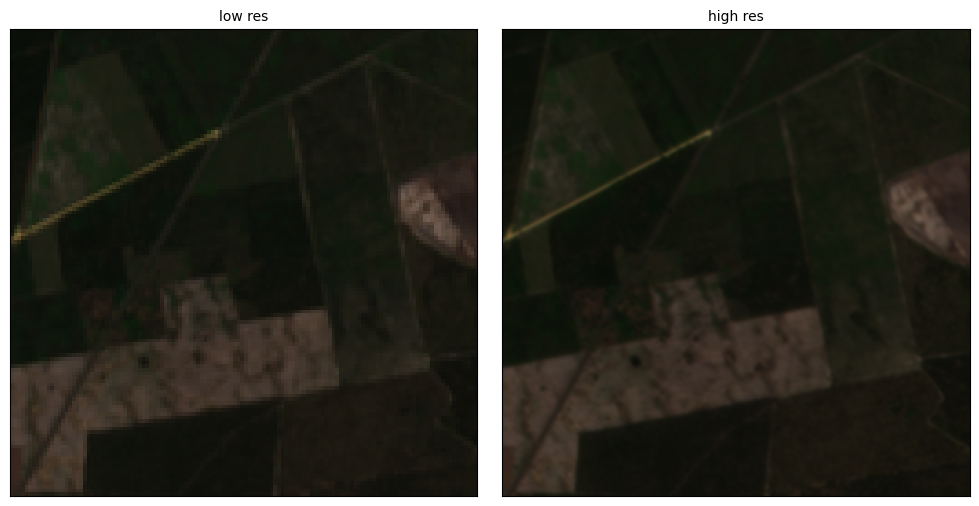

In [74]:
index = random.randint(0, len(low_res) - 1)
low_res_example = low_res[index]


high_res_example = high_res[index]


plot_gallery(
    [
        adjust_brightness(low_res_example, 2).permute(1, 2, 0),
        adjust_brightness(high_res_example, 2).permute(1, 2, 0),
    ],
    titles=["low res", "high res"],
    xscale=5,
    yscale=5,
)

In [10]:
del train_loader

## Training

In [11]:
# For clearing GPU memory
# 1 / 0

In [11]:
# For clearing GPU memory
import gc

gc.collect()
torch.cuda.empty_cache()

In [12]:
BATCH_SIZE = 16
GEN_LEARNING_RATE = 1e-5
DISCRIM_LEARNING_RATE = 1e-5
GEN_WEIGHT_DECAY = 1e-8
DISCRIM_WEIGHT_DECAY = 1e-8
DISCRIM_WEIGHT = 1e-6

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
should_pin_memory = {"cuda": True, "cpu": False}

train_loader = DataLoader(
    train_patches,
    shuffle=True,
    batch_size=BATCH_SIZE,
    drop_last=True,
    pin_memory=should_pin_memory[device.type],
    num_workers=0,
)

In [14]:
device

device(type='cuda')

In [31]:
generator = SRResNet(scaling_factor=2, n_blocks=8)

In [36]:
discriminator = Discriminator(n_blocks=2, fc_size=128)

In [37]:
generator = generator.to(device)
generator = generator.train()
discriminator = discriminator.to(device)
discriminator = discriminator.train()

In [38]:
gen_optimizer = optim.Adam(
    generator.parameters(), lr=GEN_LEARNING_RATE, weight_decay=GEN_WEIGHT_DECAY
)

discrim_optimizer = optim.Adam(
    discriminator.parameters(),
    lr=DISCRIM_LEARNING_RATE,
    weight_decay=DISCRIM_WEIGHT_DECAY,
)

In [39]:
save_file = RESULTS_DIR / "greatsrgan_withoutbatchnorm_firstbeatbicubic3_longtrain.pkl"
loaded_experiment = torch.load(save_file, map_location=device)
# generator = SRResNet(scaling_factor=2, n_blocks=16).to(device)
# discriminator = Discriminator(n_blocks=3, fc_size=128)
generator.load_state_dict(loaded_experiment["gen_state"])
discriminator.load_state_dict(loaded_experiment["discrim_state"])
gen_optimizer.load_state_dict(loaded_experiment["gen_optimizer_state"])
discrim_optimizer.load_state_dict(loaded_experiment["discrim_optimizer_state"])
gen_losses = loaded_experiment["gen_losses"]
discrim_losses = loaded_experiment["discrim_losses"]

In [40]:
pixel_criterion = nn.MSELoss()
discrim_criterion = nn.BCEWithLogitsLoss()

In [22]:
NUM_EPOCHS = 2000

In [23]:
train_time = 0.0
gen_losses = []
discrim_losses = []

In [24]:
generator = generator.to(device)
generator = generator.train()
discriminator = discriminator.to(device)
discriminator = discriminator.train()

for epoch in range(NUM_EPOCHS):
    progress_bar = tqdm.tqdm(train_loader, total=len(train_loader), ncols=100)
    gen_epoch_loss = 0.0
    discrim_epoch_loss = 0.0
    num_batches = 0
    for i, (low_res_batch, high_res_batch) in enumerate(progress_bar):
        num_batches += 1
        start_time = time.time()

        # Push to GPU
        low_res_batch = low_res_batch.to(device)
        high_res_batch = high_res_batch.to(device)

        # Update generator
        ############################################################################################
        super_resolved = generator(low_res_batch)
        natural_probs = discriminator(super_resolved)

        pixel_loss = pixel_criterion(super_resolved, high_res_batch)
        adversarial_loss = discrim_criterion(
            natural_probs, torch.ones_like(natural_probs)
        )
        gen_loss = pixel_loss

        gen_loss += DISCRIM_WEIGHT * adversarial_loss

        gen_optimizer.zero_grad()
        gen_loss.backward()
        gen_optimizer.step()

        # Update discriminator
        ############################################################################################
        true_natural_probs = discriminator(high_res_batch)

        # Detach to skip generator computations
        fake_natural_probs = discriminator(super_resolved.detach())

        true_natural_loss = discrim_criterion(
            true_natural_probs, torch.ones_like(true_natural_probs)
        )
        fake_natural_loss = discrim_criterion(
            fake_natural_probs, torch.zeros_like(fake_natural_probs)
        )
        discrim_loss = true_natural_loss + fake_natural_loss

        discrim_optimizer.zero_grad()
        discrim_loss.backward()
        discrim_optimizer.step()

        # Collect data
        gen_epoch_loss += gen_loss.item()
        discrim_epoch_loss += discrim_loss.item()
        progress_bar.set_postfix(
            epoch=epoch,
            gen_loss=f"{gen_epoch_loss/num_batches:.8f}",
            discrim_loss=f"{discrim_epoch_loss/num_batches:.8f}",
        )

        end_time = time.time()
        train_time += end_time - start_time

    gen_epoch_loss /= len(train_loader)
    discrim_epoch_loss /= len(train_loader)
    gen_losses.append(gen_epoch_loss)
    discrim_losses.append(discrim_epoch_loss)
    print(
        f"Epoch: {epoch} / gen_loss: {gen_epoch_loss:.8f} / discrim_loss: {discrim_epoch_loss:.8f}"
    )

100%|████████| 32/32 [00:12<00:00,  2.65it/s, discrim_loss=1.25096570, epoch=0, gen_loss=0.18289431]


Epoch: 0 / gen_loss: 0.18289431 / discrim_loss: 1.25096570


100%|████████| 32/32 [00:11<00:00,  2.71it/s, discrim_loss=1.07636528, epoch=1, gen_loss=0.16671455]


Epoch: 1 / gen_loss: 0.16671455 / discrim_loss: 1.07636528


100%|████████| 32/32 [00:11<00:00,  2.70it/s, discrim_loss=1.04226480, epoch=2, gen_loss=0.12747527]


Epoch: 2 / gen_loss: 0.12747527 / discrim_loss: 1.04226480


100%|████████| 32/32 [00:11<00:00,  2.70it/s, discrim_loss=1.10416902, epoch=3, gen_loss=0.05353689]


Epoch: 3 / gen_loss: 0.05353689 / discrim_loss: 1.10416902


100%|████████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=1.12409312, epoch=4, gen_loss=0.01106572]


Epoch: 4 / gen_loss: 0.01106572 / discrim_loss: 1.12409312


100%|████████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.98156952, epoch=5, gen_loss=0.00619992]


Epoch: 5 / gen_loss: 0.00619992 / discrim_loss: 0.98156952


100%|████████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.82573931, epoch=6, gen_loss=0.00568862]


Epoch: 6 / gen_loss: 0.00568862 / discrim_loss: 0.82573931


100%|████████| 32/32 [00:11<00:00,  2.67it/s, discrim_loss=0.68721787, epoch=7, gen_loss=0.00557400]


Epoch: 7 / gen_loss: 0.00557400 / discrim_loss: 0.68721787


100%|████████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.57016248, epoch=8, gen_loss=0.00547714]


Epoch: 8 / gen_loss: 0.00547714 / discrim_loss: 0.57016248


100%|████████| 32/32 [00:11<00:00,  2.68it/s, discrim_loss=0.47388919, epoch=9, gen_loss=0.00540823]


Epoch: 9 / gen_loss: 0.00540823 / discrim_loss: 0.47388919


100%|███████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.39699060, epoch=10, gen_loss=0.00538059]


Epoch: 10 / gen_loss: 0.00538059 / discrim_loss: 0.39699060


100%|███████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.33310559, epoch=11, gen_loss=0.00531310]


Epoch: 11 / gen_loss: 0.00531310 / discrim_loss: 0.33310559


100%|███████| 32/32 [00:11<00:00,  2.67it/s, discrim_loss=0.28371918, epoch=12, gen_loss=0.00526761]


Epoch: 12 / gen_loss: 0.00526761 / discrim_loss: 0.28371918


100%|███████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.24317155, epoch=13, gen_loss=0.00521130]


Epoch: 13 / gen_loss: 0.00521130 / discrim_loss: 0.24317155


100%|███████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.20870554, epoch=14, gen_loss=0.00513552]


Epoch: 14 / gen_loss: 0.00513552 / discrim_loss: 0.20870554


100%|███████| 32/32 [00:11<00:00,  2.68it/s, discrim_loss=0.18397864, epoch=15, gen_loss=0.00501961]


Epoch: 15 / gen_loss: 0.00501961 / discrim_loss: 0.18397864


100%|███████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.15988930, epoch=16, gen_loss=0.00490933]


Epoch: 16 / gen_loss: 0.00490933 / discrim_loss: 0.15988930


100%|███████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.14168683, epoch=17, gen_loss=0.00477619]


Epoch: 17 / gen_loss: 0.00477619 / discrim_loss: 0.14168683


100%|███████| 32/32 [00:11<00:00,  2.68it/s, discrim_loss=0.12329602, epoch=18, gen_loss=0.00458152]


Epoch: 18 / gen_loss: 0.00458152 / discrim_loss: 0.12329602


100%|███████| 32/32 [00:11<00:00,  2.68it/s, discrim_loss=0.10871486, epoch=19, gen_loss=0.00437006]


Epoch: 19 / gen_loss: 0.00437006 / discrim_loss: 0.10871486


100%|███████| 32/32 [00:11<00:00,  2.67it/s, discrim_loss=0.09523744, epoch=20, gen_loss=0.00407937]


Epoch: 20 / gen_loss: 0.00407937 / discrim_loss: 0.09523744


100%|███████| 32/32 [00:12<00:00,  2.65it/s, discrim_loss=0.08458944, epoch=21, gen_loss=0.00359445]


Epoch: 21 / gen_loss: 0.00359445 / discrim_loss: 0.08458944


100%|███████| 32/32 [00:12<00:00,  2.61it/s, discrim_loss=0.07672795, epoch=22, gen_loss=0.00282238]


Epoch: 22 / gen_loss: 0.00282238 / discrim_loss: 0.07672795


100%|███████| 32/32 [00:12<00:00,  2.66it/s, discrim_loss=0.10490048, epoch=23, gen_loss=0.00187974]


Epoch: 23 / gen_loss: 0.00187974 / discrim_loss: 0.10490048


100%|███████| 32/32 [00:11<00:00,  2.67it/s, discrim_loss=0.15347422, epoch=24, gen_loss=0.00132468]


Epoch: 24 / gen_loss: 0.00132468 / discrim_loss: 0.15347422


100%|███████| 32/32 [00:11<00:00,  2.67it/s, discrim_loss=0.14095604, epoch=25, gen_loss=0.00117342]


Epoch: 25 / gen_loss: 0.00117342 / discrim_loss: 0.14095604


100%|███████| 32/32 [00:11<00:00,  2.68it/s, discrim_loss=0.12386117, epoch=26, gen_loss=0.00113151]


Epoch: 26 / gen_loss: 0.00113151 / discrim_loss: 0.12386117


100%|███████| 32/32 [00:11<00:00,  2.67it/s, discrim_loss=0.10694325, epoch=27, gen_loss=0.00109853]


Epoch: 27 / gen_loss: 0.00109853 / discrim_loss: 0.10694325


100%|███████| 32/32 [00:11<00:00,  2.68it/s, discrim_loss=0.09551947, epoch=28, gen_loss=0.00107129]


Epoch: 28 / gen_loss: 0.00107129 / discrim_loss: 0.09551947


100%|███████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.08648300, epoch=29, gen_loss=0.00104741]


Epoch: 29 / gen_loss: 0.00104741 / discrim_loss: 0.08648300


100%|███████| 32/32 [00:11<00:00,  2.68it/s, discrim_loss=0.07725520, epoch=30, gen_loss=0.00102479]


Epoch: 30 / gen_loss: 0.00102479 / discrim_loss: 0.07725520


100%|███████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.07152856, epoch=31, gen_loss=0.00100427]


Epoch: 31 / gen_loss: 0.00100427 / discrim_loss: 0.07152856


100%|███████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.06476411, epoch=32, gen_loss=0.00098703]


Epoch: 32 / gen_loss: 0.00098703 / discrim_loss: 0.06476411


100%|███████| 32/32 [00:11<00:00,  2.67it/s, discrim_loss=0.06067077, epoch=33, gen_loss=0.00096706]


Epoch: 33 / gen_loss: 0.00096706 / discrim_loss: 0.06067077


100%|███████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.05694732, epoch=34, gen_loss=0.00095362]


Epoch: 34 / gen_loss: 0.00095362 / discrim_loss: 0.05694732


100%|███████| 32/32 [00:11<00:00,  2.68it/s, discrim_loss=0.05236645, epoch=35, gen_loss=0.00093754]


Epoch: 35 / gen_loss: 0.00093754 / discrim_loss: 0.05236645


100%|███████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.04962727, epoch=36, gen_loss=0.00092605]


Epoch: 36 / gen_loss: 0.00092605 / discrim_loss: 0.04962727


100%|███████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.04654042, epoch=37, gen_loss=0.00091336]


Epoch: 37 / gen_loss: 0.00091336 / discrim_loss: 0.04654042


100%|███████| 32/32 [00:11<00:00,  2.68it/s, discrim_loss=0.04403188, epoch=38, gen_loss=0.00090056]


Epoch: 38 / gen_loss: 0.00090056 / discrim_loss: 0.04403188


100%|███████| 32/32 [00:11<00:00,  2.70it/s, discrim_loss=0.04102770, epoch=39, gen_loss=0.00088837]


Epoch: 39 / gen_loss: 0.00088837 / discrim_loss: 0.04102770


100%|███████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.03846463, epoch=40, gen_loss=0.00087727]


Epoch: 40 / gen_loss: 0.00087727 / discrim_loss: 0.03846463


100%|███████| 32/32 [00:11<00:00,  2.68it/s, discrim_loss=0.03685751, epoch=41, gen_loss=0.00086517]


Epoch: 41 / gen_loss: 0.00086517 / discrim_loss: 0.03685751


100%|███████| 32/32 [00:11<00:00,  2.67it/s, discrim_loss=0.03544181, epoch=42, gen_loss=0.00085713]


Epoch: 42 / gen_loss: 0.00085713 / discrim_loss: 0.03544181


100%|███████| 32/32 [00:11<00:00,  2.68it/s, discrim_loss=0.03241087, epoch=43, gen_loss=0.00084653]


Epoch: 43 / gen_loss: 0.00084653 / discrim_loss: 0.03241087


100%|███████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.03171857, epoch=44, gen_loss=0.00083475]


Epoch: 44 / gen_loss: 0.00083475 / discrim_loss: 0.03171857


100%|███████| 32/32 [00:11<00:00,  2.68it/s, discrim_loss=0.02981811, epoch=45, gen_loss=0.00082631]


Epoch: 45 / gen_loss: 0.00082631 / discrim_loss: 0.02981811


100%|███████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.02836756, epoch=46, gen_loss=0.00081721]


Epoch: 46 / gen_loss: 0.00081721 / discrim_loss: 0.02836756


100%|███████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.02707186, epoch=47, gen_loss=0.00080739]


Epoch: 47 / gen_loss: 0.00080739 / discrim_loss: 0.02707186


100%|███████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.02591289, epoch=48, gen_loss=0.00079807]


Epoch: 48 / gen_loss: 0.00079807 / discrim_loss: 0.02591289


100%|███████| 32/32 [00:11<00:00,  2.68it/s, discrim_loss=0.02481510, epoch=49, gen_loss=0.00078925]


Epoch: 49 / gen_loss: 0.00078925 / discrim_loss: 0.02481510


100%|███████| 32/32 [00:11<00:00,  2.70it/s, discrim_loss=0.02390222, epoch=50, gen_loss=0.00077883]


Epoch: 50 / gen_loss: 0.00077883 / discrim_loss: 0.02390222


100%|███████| 32/32 [00:11<00:00,  2.70it/s, discrim_loss=0.02248274, epoch=51, gen_loss=0.00077117]


Epoch: 51 / gen_loss: 0.00077117 / discrim_loss: 0.02248274


100%|███████| 32/32 [00:11<00:00,  2.68it/s, discrim_loss=0.02186810, epoch=52, gen_loss=0.00076225]


Epoch: 52 / gen_loss: 0.00076225 / discrim_loss: 0.02186810


100%|███████| 32/32 [00:11<00:00,  2.70it/s, discrim_loss=0.02137666, epoch=53, gen_loss=0.00075292]


Epoch: 53 / gen_loss: 0.00075292 / discrim_loss: 0.02137666


100%|███████| 32/32 [00:11<00:00,  2.70it/s, discrim_loss=0.02042228, epoch=54, gen_loss=0.00074521]


Epoch: 54 / gen_loss: 0.00074521 / discrim_loss: 0.02042228


100%|███████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.01980681, epoch=55, gen_loss=0.00073563]


Epoch: 55 / gen_loss: 0.00073563 / discrim_loss: 0.01980681


100%|███████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.01952032, epoch=56, gen_loss=0.00072837]


Epoch: 56 / gen_loss: 0.00072837 / discrim_loss: 0.01952032


100%|███████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.01853843, epoch=57, gen_loss=0.00071809]


Epoch: 57 / gen_loss: 0.00071809 / discrim_loss: 0.01853843


100%|███████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.01836175, epoch=58, gen_loss=0.00071156]


Epoch: 58 / gen_loss: 0.00071156 / discrim_loss: 0.01836175


100%|███████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.01778134, epoch=59, gen_loss=0.00070187]


Epoch: 59 / gen_loss: 0.00070187 / discrim_loss: 0.01778134


100%|███████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.01700931, epoch=60, gen_loss=0.00069359]


Epoch: 60 / gen_loss: 0.00069359 / discrim_loss: 0.01700931


100%|███████| 32/32 [00:11<00:00,  2.68it/s, discrim_loss=0.01644941, epoch=61, gen_loss=0.00068525]


Epoch: 61 / gen_loss: 0.00068525 / discrim_loss: 0.01644941


100%|███████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.01716026, epoch=62, gen_loss=0.00067731]


Epoch: 62 / gen_loss: 0.00067731 / discrim_loss: 0.01716026


100%|███████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.01635650, epoch=63, gen_loss=0.00066952]


Epoch: 63 / gen_loss: 0.00066952 / discrim_loss: 0.01635650


100%|███████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.01639270, epoch=64, gen_loss=0.00066054]


Epoch: 64 / gen_loss: 0.00066054 / discrim_loss: 0.01639270


100%|███████| 32/32 [00:11<00:00,  2.70it/s, discrim_loss=0.01591394, epoch=65, gen_loss=0.00065101]


Epoch: 65 / gen_loss: 0.00065101 / discrim_loss: 0.01591394


100%|███████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.01593368, epoch=66, gen_loss=0.00064437]


Epoch: 66 / gen_loss: 0.00064437 / discrim_loss: 0.01593368


100%|███████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.01574352, epoch=67, gen_loss=0.00063408]


Epoch: 67 / gen_loss: 0.00063408 / discrim_loss: 0.01574352


100%|███████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.01583755, epoch=68, gen_loss=0.00062685]


Epoch: 68 / gen_loss: 0.00062685 / discrim_loss: 0.01583755


100%|███████| 32/32 [00:11<00:00,  2.68it/s, discrim_loss=0.01555628, epoch=69, gen_loss=0.00061863]


Epoch: 69 / gen_loss: 0.00061863 / discrim_loss: 0.01555628


100%|███████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.01583280, epoch=70, gen_loss=0.00061121]


Epoch: 70 / gen_loss: 0.00061121 / discrim_loss: 0.01583280


100%|███████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.01591619, epoch=71, gen_loss=0.00060225]


Epoch: 71 / gen_loss: 0.00060225 / discrim_loss: 0.01591619


100%|███████| 32/32 [00:11<00:00,  2.70it/s, discrim_loss=0.01650686, epoch=72, gen_loss=0.00059365]


Epoch: 72 / gen_loss: 0.00059365 / discrim_loss: 0.01650686


100%|███████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.01553703, epoch=73, gen_loss=0.00058571]


Epoch: 73 / gen_loss: 0.00058571 / discrim_loss: 0.01553703


100%|███████| 32/32 [00:11<00:00,  2.68it/s, discrim_loss=0.01547908, epoch=74, gen_loss=0.00057751]


Epoch: 74 / gen_loss: 0.00057751 / discrim_loss: 0.01547908


100%|███████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.01544550, epoch=75, gen_loss=0.00056913]


Epoch: 75 / gen_loss: 0.00056913 / discrim_loss: 0.01544550


100%|███████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.01509948, epoch=76, gen_loss=0.00056135]


Epoch: 76 / gen_loss: 0.00056135 / discrim_loss: 0.01509948


100%|███████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.01691753, epoch=77, gen_loss=0.00055201]


Epoch: 77 / gen_loss: 0.00055201 / discrim_loss: 0.01691753


100%|███████| 32/32 [00:11<00:00,  2.68it/s, discrim_loss=0.01502449, epoch=78, gen_loss=0.00054598]


Epoch: 78 / gen_loss: 0.00054598 / discrim_loss: 0.01502449


100%|███████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.01525649, epoch=79, gen_loss=0.00053631]


Epoch: 79 / gen_loss: 0.00053631 / discrim_loss: 0.01525649


100%|███████| 32/32 [00:11<00:00,  2.68it/s, discrim_loss=0.01484848, epoch=80, gen_loss=0.00052822]


Epoch: 80 / gen_loss: 0.00052822 / discrim_loss: 0.01484848


100%|███████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.01410007, epoch=81, gen_loss=0.00051971]


Epoch: 81 / gen_loss: 0.00051971 / discrim_loss: 0.01410007


100%|███████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.01401634, epoch=82, gen_loss=0.00051121]


Epoch: 82 / gen_loss: 0.00051121 / discrim_loss: 0.01401634


100%|███████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.01416416, epoch=83, gen_loss=0.00050387]


Epoch: 83 / gen_loss: 0.00050387 / discrim_loss: 0.01416416


100%|███████| 32/32 [00:11<00:00,  2.68it/s, discrim_loss=0.01292290, epoch=84, gen_loss=0.00049492]


Epoch: 84 / gen_loss: 0.00049492 / discrim_loss: 0.01292290


100%|███████| 32/32 [00:11<00:00,  2.70it/s, discrim_loss=0.01306902, epoch=85, gen_loss=0.00048555]


Epoch: 85 / gen_loss: 0.00048555 / discrim_loss: 0.01306902


100%|███████| 32/32 [00:11<00:00,  2.68it/s, discrim_loss=0.01357300, epoch=86, gen_loss=0.00047794]


Epoch: 86 / gen_loss: 0.00047794 / discrim_loss: 0.01357300


100%|███████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.01275415, epoch=87, gen_loss=0.00047001]


Epoch: 87 / gen_loss: 0.00047001 / discrim_loss: 0.01275415


100%|███████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.01219009, epoch=88, gen_loss=0.00046112]


Epoch: 88 / gen_loss: 0.00046112 / discrim_loss: 0.01219009


100%|███████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.01167792, epoch=89, gen_loss=0.00045314]


Epoch: 89 / gen_loss: 0.00045314 / discrim_loss: 0.01167792


100%|███████| 32/32 [00:12<00:00,  2.66it/s, discrim_loss=0.01181422, epoch=90, gen_loss=0.00044411]


Epoch: 90 / gen_loss: 0.00044411 / discrim_loss: 0.01181422


100%|███████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.01183619, epoch=91, gen_loss=0.00043576]


Epoch: 91 / gen_loss: 0.00043576 / discrim_loss: 0.01183619


100%|███████| 32/32 [00:11<00:00,  2.70it/s, discrim_loss=0.01168560, epoch=92, gen_loss=0.00042771]


Epoch: 92 / gen_loss: 0.00042771 / discrim_loss: 0.01168560


100%|███████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.01143249, epoch=93, gen_loss=0.00042006]


Epoch: 93 / gen_loss: 0.00042006 / discrim_loss: 0.01143249


100%|███████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.01085386, epoch=94, gen_loss=0.00041135]


Epoch: 94 / gen_loss: 0.00041135 / discrim_loss: 0.01085386


100%|███████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.01111591, epoch=95, gen_loss=0.00040153]


Epoch: 95 / gen_loss: 0.00040153 / discrim_loss: 0.01111591


100%|███████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.01179032, epoch=96, gen_loss=0.00039443]


Epoch: 96 / gen_loss: 0.00039443 / discrim_loss: 0.01179032


100%|███████| 32/32 [00:11<00:00,  2.70it/s, discrim_loss=0.01087577, epoch=97, gen_loss=0.00038655]


Epoch: 97 / gen_loss: 0.00038655 / discrim_loss: 0.01087577


100%|███████| 32/32 [00:11<00:00,  2.68it/s, discrim_loss=0.01175690, epoch=98, gen_loss=0.00037872]


Epoch: 98 / gen_loss: 0.00037872 / discrim_loss: 0.01175690


100%|███████| 32/32 [00:11<00:00,  2.68it/s, discrim_loss=0.01113976, epoch=99, gen_loss=0.00037323]


Epoch: 99 / gen_loss: 0.00037323 / discrim_loss: 0.01113976


100%|██████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.01048520, epoch=100, gen_loss=0.00036515]


Epoch: 100 / gen_loss: 0.00036515 / discrim_loss: 0.01048520


100%|██████| 32/32 [00:11<00:00,  2.68it/s, discrim_loss=0.01045240, epoch=101, gen_loss=0.00035810]


Epoch: 101 / gen_loss: 0.00035810 / discrim_loss: 0.01045240


100%|██████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.01049893, epoch=102, gen_loss=0.00035123]


Epoch: 102 / gen_loss: 0.00035123 / discrim_loss: 0.01049893


100%|██████| 32/32 [00:11<00:00,  2.70it/s, discrim_loss=0.01005125, epoch=103, gen_loss=0.00034502]


Epoch: 103 / gen_loss: 0.00034502 / discrim_loss: 0.01005125


100%|██████| 32/32 [00:11<00:00,  2.67it/s, discrim_loss=0.01023630, epoch=104, gen_loss=0.00034061]


Epoch: 104 / gen_loss: 0.00034061 / discrim_loss: 0.01023630


100%|██████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.01038078, epoch=105, gen_loss=0.00033309]


Epoch: 105 / gen_loss: 0.00033309 / discrim_loss: 0.01038078


100%|██████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.01004496, epoch=106, gen_loss=0.00032765]


Epoch: 106 / gen_loss: 0.00032765 / discrim_loss: 0.01004496


100%|██████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.01026620, epoch=107, gen_loss=0.00032298]


Epoch: 107 / gen_loss: 0.00032298 / discrim_loss: 0.01026620


100%|██████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.01090163, epoch=108, gen_loss=0.00031843]


Epoch: 108 / gen_loss: 0.00031843 / discrim_loss: 0.01090163


100%|██████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.01009715, epoch=109, gen_loss=0.00031395]


Epoch: 109 / gen_loss: 0.00031395 / discrim_loss: 0.01009715


100%|██████| 32/32 [00:11<00:00,  2.70it/s, discrim_loss=0.01060339, epoch=110, gen_loss=0.00031136]


Epoch: 110 / gen_loss: 0.00031136 / discrim_loss: 0.01060339


100%|██████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.01020635, epoch=111, gen_loss=0.00030625]


Epoch: 111 / gen_loss: 0.00030625 / discrim_loss: 0.01020635


100%|██████| 32/32 [00:11<00:00,  2.68it/s, discrim_loss=0.00982955, epoch=112, gen_loss=0.00030276]


Epoch: 112 / gen_loss: 0.00030276 / discrim_loss: 0.00982955


100%|██████| 32/32 [00:11<00:00,  2.68it/s, discrim_loss=0.00974944, epoch=113, gen_loss=0.00029960]


Epoch: 113 / gen_loss: 0.00029960 / discrim_loss: 0.00974944


100%|██████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.00972897, epoch=114, gen_loss=0.00029622]


Epoch: 114 / gen_loss: 0.00029622 / discrim_loss: 0.00972897


100%|██████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.00968520, epoch=115, gen_loss=0.00029179]


Epoch: 115 / gen_loss: 0.00029179 / discrim_loss: 0.00968520


100%|██████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.00988749, epoch=116, gen_loss=0.00029104]


Epoch: 116 / gen_loss: 0.00029104 / discrim_loss: 0.00988749


100%|██████| 32/32 [00:11<00:00,  2.67it/s, discrim_loss=0.00921886, epoch=117, gen_loss=0.00028705]


Epoch: 117 / gen_loss: 0.00028705 / discrim_loss: 0.00921886


100%|██████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.00888512, epoch=118, gen_loss=0.00028482]


Epoch: 118 / gen_loss: 0.00028482 / discrim_loss: 0.00888512


100%|██████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.00909665, epoch=119, gen_loss=0.00028442]


Epoch: 119 / gen_loss: 0.00028442 / discrim_loss: 0.00909665


100%|██████| 32/32 [00:11<00:00,  2.67it/s, discrim_loss=0.00957066, epoch=120, gen_loss=0.00028117]


Epoch: 120 / gen_loss: 0.00028117 / discrim_loss: 0.00957066


100%|██████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.00971442, epoch=121, gen_loss=0.00027840]


Epoch: 121 / gen_loss: 0.00027840 / discrim_loss: 0.00971442


100%|██████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.00864640, epoch=122, gen_loss=0.00027775]


Epoch: 122 / gen_loss: 0.00027775 / discrim_loss: 0.00864640


100%|██████| 32/32 [00:11<00:00,  2.68it/s, discrim_loss=0.00962739, epoch=123, gen_loss=0.00027467]


Epoch: 123 / gen_loss: 0.00027467 / discrim_loss: 0.00962739


100%|██████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.00779362, epoch=124, gen_loss=0.00027243]


Epoch: 124 / gen_loss: 0.00027243 / discrim_loss: 0.00779362


100%|██████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.00784480, epoch=125, gen_loss=0.00027083]


Epoch: 125 / gen_loss: 0.00027083 / discrim_loss: 0.00784480


100%|██████| 32/32 [00:11<00:00,  2.70it/s, discrim_loss=0.00837958, epoch=126, gen_loss=0.00026911]


Epoch: 126 / gen_loss: 0.00026911 / discrim_loss: 0.00837958


100%|██████| 32/32 [00:11<00:00,  2.68it/s, discrim_loss=0.00777208, epoch=127, gen_loss=0.00026712]


Epoch: 127 / gen_loss: 0.00026712 / discrim_loss: 0.00777208


100%|██████| 32/32 [00:11<00:00,  2.68it/s, discrim_loss=0.00798535, epoch=128, gen_loss=0.00026678]


Epoch: 128 / gen_loss: 0.00026678 / discrim_loss: 0.00798535


100%|██████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.00726570, epoch=129, gen_loss=0.00026381]


Epoch: 129 / gen_loss: 0.00026381 / discrim_loss: 0.00726570


100%|██████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.00730561, epoch=130, gen_loss=0.00026274]


Epoch: 130 / gen_loss: 0.00026274 / discrim_loss: 0.00730561


100%|██████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.00767429, epoch=131, gen_loss=0.00026331]


Epoch: 131 / gen_loss: 0.00026331 / discrim_loss: 0.00767429


100%|██████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.00767474, epoch=132, gen_loss=0.00025998]


Epoch: 132 / gen_loss: 0.00025998 / discrim_loss: 0.00767474


100%|██████| 32/32 [00:11<00:00,  2.68it/s, discrim_loss=0.00748093, epoch=133, gen_loss=0.00025829]


Epoch: 133 / gen_loss: 0.00025829 / discrim_loss: 0.00748093


100%|██████| 32/32 [00:11<00:00,  2.68it/s, discrim_loss=0.00654906, epoch=134, gen_loss=0.00025707]


Epoch: 134 / gen_loss: 0.00025707 / discrim_loss: 0.00654906


100%|██████| 32/32 [00:11<00:00,  2.67it/s, discrim_loss=0.00691029, epoch=135, gen_loss=0.00025684]


Epoch: 135 / gen_loss: 0.00025684 / discrim_loss: 0.00691029


100%|██████| 32/32 [00:11<00:00,  2.68it/s, discrim_loss=0.00722503, epoch=136, gen_loss=0.00025481]


Epoch: 136 / gen_loss: 0.00025481 / discrim_loss: 0.00722503


100%|██████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.00690576, epoch=137, gen_loss=0.00025429]


Epoch: 137 / gen_loss: 0.00025429 / discrim_loss: 0.00690576


100%|██████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.00664656, epoch=138, gen_loss=0.00025319]


Epoch: 138 / gen_loss: 0.00025319 / discrim_loss: 0.00664656


100%|██████| 32/32 [00:11<00:00,  2.67it/s, discrim_loss=0.00657411, epoch=139, gen_loss=0.00025207]


Epoch: 139 / gen_loss: 0.00025207 / discrim_loss: 0.00657411


100%|██████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.00645307, epoch=140, gen_loss=0.00025147]


Epoch: 140 / gen_loss: 0.00025147 / discrim_loss: 0.00645307


100%|██████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.00651851, epoch=141, gen_loss=0.00025131]


Epoch: 141 / gen_loss: 0.00025131 / discrim_loss: 0.00651851


100%|██████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.00577718, epoch=142, gen_loss=0.00025029]


Epoch: 142 / gen_loss: 0.00025029 / discrim_loss: 0.00577718


100%|██████| 32/32 [00:11<00:00,  2.67it/s, discrim_loss=0.00619566, epoch=143, gen_loss=0.00024941]


Epoch: 143 / gen_loss: 0.00024941 / discrim_loss: 0.00619566


100%|██████| 32/32 [00:11<00:00,  2.70it/s, discrim_loss=0.00662286, epoch=144, gen_loss=0.00024705]


Epoch: 144 / gen_loss: 0.00024705 / discrim_loss: 0.00662286


100%|██████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.00606632, epoch=145, gen_loss=0.00024714]


Epoch: 145 / gen_loss: 0.00024714 / discrim_loss: 0.00606632


100%|██████| 32/32 [00:11<00:00,  2.70it/s, discrim_loss=0.00598291, epoch=146, gen_loss=0.00024579]


Epoch: 146 / gen_loss: 0.00024579 / discrim_loss: 0.00598291


100%|██████| 32/32 [00:11<00:00,  2.68it/s, discrim_loss=0.00619268, epoch=147, gen_loss=0.00024459]


Epoch: 147 / gen_loss: 0.00024459 / discrim_loss: 0.00619268


100%|██████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.00549571, epoch=148, gen_loss=0.00024316]


Epoch: 148 / gen_loss: 0.00024316 / discrim_loss: 0.00549571


100%|██████| 32/32 [00:11<00:00,  2.69it/s, discrim_loss=0.00588028, epoch=149, gen_loss=0.00024328]


Epoch: 149 / gen_loss: 0.00024328 / discrim_loss: 0.00588028


100%|██████| 32/32 [00:11<00:00,  2.67it/s, discrim_loss=0.00587062, epoch=150, gen_loss=0.00024193]


Epoch: 150 / gen_loss: 0.00024193 / discrim_loss: 0.00587062


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.00538426, epoch=151, gen_loss=0.00024315]


Epoch: 151 / gen_loss: 0.00024315 / discrim_loss: 0.00538426


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.00560469, epoch=152, gen_loss=0.00024202]


Epoch: 152 / gen_loss: 0.00024202 / discrim_loss: 0.00560469


100%|██████| 32/32 [00:11<00:00,  2.71it/s, discrim_loss=0.00504110, epoch=153, gen_loss=0.00023953]


Epoch: 153 / gen_loss: 0.00023953 / discrim_loss: 0.00504110


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.00518623, epoch=154, gen_loss=0.00023738]


Epoch: 154 / gen_loss: 0.00023738 / discrim_loss: 0.00518623


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.00520871, epoch=155, gen_loss=0.00023849]


Epoch: 155 / gen_loss: 0.00023849 / discrim_loss: 0.00520871


100%|██████| 32/32 [00:11<00:00,  2.71it/s, discrim_loss=0.00512113, epoch=156, gen_loss=0.00023681]


Epoch: 156 / gen_loss: 0.00023681 / discrim_loss: 0.00512113


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.00543952, epoch=157, gen_loss=0.00023610]


Epoch: 157 / gen_loss: 0.00023610 / discrim_loss: 0.00543952


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.00497659, epoch=158, gen_loss=0.00023566]


Epoch: 158 / gen_loss: 0.00023566 / discrim_loss: 0.00497659


100%|██████| 32/32 [00:11<00:00,  2.71it/s, discrim_loss=0.00488737, epoch=159, gen_loss=0.00023402]


Epoch: 159 / gen_loss: 0.00023402 / discrim_loss: 0.00488737


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.00507530, epoch=160, gen_loss=0.00023310]


Epoch: 160 / gen_loss: 0.00023310 / discrim_loss: 0.00507530


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.00469302, epoch=161, gen_loss=0.00023280]


Epoch: 161 / gen_loss: 0.00023280 / discrim_loss: 0.00469302


100%|██████| 32/32 [00:11<00:00,  2.72it/s, discrim_loss=0.00480419, epoch=162, gen_loss=0.00023365]


Epoch: 162 / gen_loss: 0.00023365 / discrim_loss: 0.00480419


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.00477184, epoch=163, gen_loss=0.00023188]


Epoch: 163 / gen_loss: 0.00023188 / discrim_loss: 0.00477184


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.00475953, epoch=164, gen_loss=0.00023175]


Epoch: 164 / gen_loss: 0.00023175 / discrim_loss: 0.00475953


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.00492834, epoch=165, gen_loss=0.00022924]


Epoch: 165 / gen_loss: 0.00022924 / discrim_loss: 0.00492834


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.00455016, epoch=166, gen_loss=0.00022914]


Epoch: 166 / gen_loss: 0.00022914 / discrim_loss: 0.00455016


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.00498308, epoch=167, gen_loss=0.00022922]


Epoch: 167 / gen_loss: 0.00022922 / discrim_loss: 0.00498308


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.00537602, epoch=168, gen_loss=0.00022861]


Epoch: 168 / gen_loss: 0.00022861 / discrim_loss: 0.00537602


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.00500482, epoch=169, gen_loss=0.00022656]


Epoch: 169 / gen_loss: 0.00022656 / discrim_loss: 0.00500482


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.00501342, epoch=170, gen_loss=0.00022642]


Epoch: 170 / gen_loss: 0.00022642 / discrim_loss: 0.00501342


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.00477499, epoch=171, gen_loss=0.00022562]


Epoch: 171 / gen_loss: 0.00022562 / discrim_loss: 0.00477499


100%|██████| 32/32 [00:11<00:00,  2.71it/s, discrim_loss=0.00431851, epoch=172, gen_loss=0.00022581]


Epoch: 172 / gen_loss: 0.00022581 / discrim_loss: 0.00431851


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.00516746, epoch=173, gen_loss=0.00022426]


Epoch: 173 / gen_loss: 0.00022426 / discrim_loss: 0.00516746


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.00498359, epoch=174, gen_loss=0.00022355]


Epoch: 174 / gen_loss: 0.00022355 / discrim_loss: 0.00498359


100%|██████| 32/32 [00:11<00:00,  2.72it/s, discrim_loss=0.00466254, epoch=175, gen_loss=0.00022236]


Epoch: 175 / gen_loss: 0.00022236 / discrim_loss: 0.00466254


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.00462498, epoch=176, gen_loss=0.00022383]


Epoch: 176 / gen_loss: 0.00022383 / discrim_loss: 0.00462498


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.00432314, epoch=177, gen_loss=0.00022176]


Epoch: 177 / gen_loss: 0.00022176 / discrim_loss: 0.00432314


100%|██████| 32/32 [00:11<00:00,  2.72it/s, discrim_loss=0.00515121, epoch=178, gen_loss=0.00022104]


Epoch: 178 / gen_loss: 0.00022104 / discrim_loss: 0.00515121


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.00503801, epoch=179, gen_loss=0.00022053]


Epoch: 179 / gen_loss: 0.00022053 / discrim_loss: 0.00503801


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.00515718, epoch=180, gen_loss=0.00021920]


Epoch: 180 / gen_loss: 0.00021920 / discrim_loss: 0.00515718


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.00488398, epoch=181, gen_loss=0.00021870]


Epoch: 181 / gen_loss: 0.00021870 / discrim_loss: 0.00488398


100%|██████| 32/32 [00:11<00:00,  2.71it/s, discrim_loss=0.00501867, epoch=182, gen_loss=0.00021847]


Epoch: 182 / gen_loss: 0.00021847 / discrim_loss: 0.00501867


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.00507962, epoch=183, gen_loss=0.00021718]


Epoch: 183 / gen_loss: 0.00021718 / discrim_loss: 0.00507962


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.00490684, epoch=184, gen_loss=0.00021735]


Epoch: 184 / gen_loss: 0.00021735 / discrim_loss: 0.00490684


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.00461634, epoch=185, gen_loss=0.00021629]


Epoch: 185 / gen_loss: 0.00021629 / discrim_loss: 0.00461634


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.00487935, epoch=186, gen_loss=0.00021608]


Epoch: 186 / gen_loss: 0.00021608 / discrim_loss: 0.00487935


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.00470421, epoch=187, gen_loss=0.00021582]


Epoch: 187 / gen_loss: 0.00021582 / discrim_loss: 0.00470421


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.00534657, epoch=188, gen_loss=0.00021405]


Epoch: 188 / gen_loss: 0.00021405 / discrim_loss: 0.00534657


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.00534557, epoch=189, gen_loss=0.00021343]


Epoch: 189 / gen_loss: 0.00021343 / discrim_loss: 0.00534557


100%|██████| 32/32 [00:11<00:00,  2.72it/s, discrim_loss=0.00485907, epoch=190, gen_loss=0.00021254]


Epoch: 190 / gen_loss: 0.00021254 / discrim_loss: 0.00485907


100%|██████| 32/32 [00:11<00:00,  2.72it/s, discrim_loss=0.00489289, epoch=191, gen_loss=0.00021331]


Epoch: 191 / gen_loss: 0.00021331 / discrim_loss: 0.00489289


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.00539488, epoch=192, gen_loss=0.00021122]


Epoch: 192 / gen_loss: 0.00021122 / discrim_loss: 0.00539488


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.00483994, epoch=193, gen_loss=0.00021296]


Epoch: 193 / gen_loss: 0.00021296 / discrim_loss: 0.00483994


100%|██████| 32/32 [00:11<00:00,  2.72it/s, discrim_loss=0.00488524, epoch=194, gen_loss=0.00020977]


Epoch: 194 / gen_loss: 0.00020977 / discrim_loss: 0.00488524


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.00484882, epoch=195, gen_loss=0.00020871]


Epoch: 195 / gen_loss: 0.00020871 / discrim_loss: 0.00484882


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.00538556, epoch=196, gen_loss=0.00020877]


Epoch: 196 / gen_loss: 0.00020877 / discrim_loss: 0.00538556


100%|██████| 32/32 [00:11<00:00,  2.72it/s, discrim_loss=0.00527490, epoch=197, gen_loss=0.00020850]


Epoch: 197 / gen_loss: 0.00020850 / discrim_loss: 0.00527490


100%|██████| 32/32 [00:11<00:00,  2.72it/s, discrim_loss=0.00462425, epoch=198, gen_loss=0.00020856]


Epoch: 198 / gen_loss: 0.00020856 / discrim_loss: 0.00462425


100%|██████| 32/32 [00:11<00:00,  2.72it/s, discrim_loss=0.00516144, epoch=199, gen_loss=0.00020765]


Epoch: 199 / gen_loss: 0.00020765 / discrim_loss: 0.00516144


100%|██████| 32/32 [00:11<00:00,  2.72it/s, discrim_loss=0.00471544, epoch=200, gen_loss=0.00020566]


Epoch: 200 / gen_loss: 0.00020566 / discrim_loss: 0.00471544


100%|██████| 32/32 [00:11<00:00,  2.72it/s, discrim_loss=0.00532759, epoch=201, gen_loss=0.00020559]


Epoch: 201 / gen_loss: 0.00020559 / discrim_loss: 0.00532759


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.00424215, epoch=202, gen_loss=0.00020543]


Epoch: 202 / gen_loss: 0.00020543 / discrim_loss: 0.00424215


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.00498676, epoch=203, gen_loss=0.00020451]


Epoch: 203 / gen_loss: 0.00020451 / discrim_loss: 0.00498676


100%|██████| 32/32 [00:11<00:00,  2.72it/s, discrim_loss=0.00510240, epoch=204, gen_loss=0.00020337]


Epoch: 204 / gen_loss: 0.00020337 / discrim_loss: 0.00510240


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.00457217, epoch=205, gen_loss=0.00020462]


Epoch: 205 / gen_loss: 0.00020462 / discrim_loss: 0.00457217


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.00472167, epoch=206, gen_loss=0.00020195]


Epoch: 206 / gen_loss: 0.00020195 / discrim_loss: 0.00472167


100%|██████| 32/32 [00:11<00:00,  2.71it/s, discrim_loss=0.00554466, epoch=207, gen_loss=0.00020194]


Epoch: 207 / gen_loss: 0.00020194 / discrim_loss: 0.00554466


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.00489420, epoch=208, gen_loss=0.00020204]


Epoch: 208 / gen_loss: 0.00020204 / discrim_loss: 0.00489420


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.00462671, epoch=209, gen_loss=0.00020006]


Epoch: 209 / gen_loss: 0.00020006 / discrim_loss: 0.00462671


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.00459557, epoch=210, gen_loss=0.00019926]


Epoch: 210 / gen_loss: 0.00019926 / discrim_loss: 0.00459557


100%|██████| 32/32 [00:11<00:00,  2.72it/s, discrim_loss=0.00512237, epoch=211, gen_loss=0.00019913]


Epoch: 211 / gen_loss: 0.00019913 / discrim_loss: 0.00512237


100%|██████| 32/32 [00:11<00:00,  2.72it/s, discrim_loss=0.00501728, epoch=212, gen_loss=0.00019811]


Epoch: 212 / gen_loss: 0.00019811 / discrim_loss: 0.00501728


100%|██████| 32/32 [00:11<00:00,  2.71it/s, discrim_loss=0.00505864, epoch=213, gen_loss=0.00019802]


Epoch: 213 / gen_loss: 0.00019802 / discrim_loss: 0.00505864


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.00479631, epoch=214, gen_loss=0.00019662]


Epoch: 214 / gen_loss: 0.00019662 / discrim_loss: 0.00479631


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.00484009, epoch=215, gen_loss=0.00019591]


Epoch: 215 / gen_loss: 0.00019591 / discrim_loss: 0.00484009


100%|██████| 32/32 [00:11<00:00,  2.72it/s, discrim_loss=0.00484338, epoch=216, gen_loss=0.00019669]


Epoch: 216 / gen_loss: 0.00019669 / discrim_loss: 0.00484338


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.00506083, epoch=217, gen_loss=0.00019523]


Epoch: 217 / gen_loss: 0.00019523 / discrim_loss: 0.00506083


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.00562350, epoch=218, gen_loss=0.00019403]


Epoch: 218 / gen_loss: 0.00019403 / discrim_loss: 0.00562350


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.00488220, epoch=219, gen_loss=0.00019332]


Epoch: 219 / gen_loss: 0.00019332 / discrim_loss: 0.00488220


100%|██████| 32/32 [00:11<00:00,  2.72it/s, discrim_loss=0.00424543, epoch=220, gen_loss=0.00019399]


Epoch: 220 / gen_loss: 0.00019399 / discrim_loss: 0.00424543


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.00416722, epoch=221, gen_loss=0.00019251]


Epoch: 221 / gen_loss: 0.00019251 / discrim_loss: 0.00416722


100%|██████| 32/32 [00:11<00:00,  2.72it/s, discrim_loss=0.00434750, epoch=222, gen_loss=0.00019112]


Epoch: 222 / gen_loss: 0.00019112 / discrim_loss: 0.00434750


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.00505608, epoch=223, gen_loss=0.00019106]


Epoch: 223 / gen_loss: 0.00019106 / discrim_loss: 0.00505608


100%|██████| 32/32 [00:11<00:00,  2.72it/s, discrim_loss=0.00508135, epoch=224, gen_loss=0.00019001]


Epoch: 224 / gen_loss: 0.00019001 / discrim_loss: 0.00508135


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.00472527, epoch=225, gen_loss=0.00019052]


Epoch: 225 / gen_loss: 0.00019052 / discrim_loss: 0.00472527


100%|██████| 32/32 [00:11<00:00,  2.71it/s, discrim_loss=0.00473066, epoch=226, gen_loss=0.00018956]


Epoch: 226 / gen_loss: 0.00018956 / discrim_loss: 0.00473066


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.00516687, epoch=227, gen_loss=0.00018775]


Epoch: 227 / gen_loss: 0.00018775 / discrim_loss: 0.00516687


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.00488190, epoch=228, gen_loss=0.00018765]


Epoch: 228 / gen_loss: 0.00018765 / discrim_loss: 0.00488190


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.00513752, epoch=229, gen_loss=0.00018686]


Epoch: 229 / gen_loss: 0.00018686 / discrim_loss: 0.00513752


100%|██████| 32/32 [00:11<00:00,  2.71it/s, discrim_loss=0.00441746, epoch=230, gen_loss=0.00018588]


Epoch: 230 / gen_loss: 0.00018588 / discrim_loss: 0.00441746


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.00482483, epoch=231, gen_loss=0.00018502]


Epoch: 231 / gen_loss: 0.00018502 / discrim_loss: 0.00482483


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.00550223, epoch=232, gen_loss=0.00018485]


Epoch: 232 / gen_loss: 0.00018485 / discrim_loss: 0.00550223


100%|██████| 32/32 [00:11<00:00,  2.72it/s, discrim_loss=0.00974119, epoch=233, gen_loss=0.00018417]


Epoch: 233 / gen_loss: 0.00018417 / discrim_loss: 0.00974119


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.00571045, epoch=234, gen_loss=0.00018339]


Epoch: 234 / gen_loss: 0.00018339 / discrim_loss: 0.00571045


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.00458768, epoch=235, gen_loss=0.00018404]


Epoch: 235 / gen_loss: 0.00018404 / discrim_loss: 0.00458768


100%|██████| 32/32 [00:11<00:00,  2.70it/s, discrim_loss=0.00434770, epoch=236, gen_loss=0.00018229]


Epoch: 236 / gen_loss: 0.00018229 / discrim_loss: 0.00434770


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.00474323, epoch=237, gen_loss=0.00018228]


Epoch: 237 / gen_loss: 0.00018228 / discrim_loss: 0.00474323


100%|██████| 32/32 [00:11<00:00,  2.71it/s, discrim_loss=0.00450416, epoch=238, gen_loss=0.00018112]


Epoch: 238 / gen_loss: 0.00018112 / discrim_loss: 0.00450416


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.00434049, epoch=239, gen_loss=0.00017939]


Epoch: 239 / gen_loss: 0.00017939 / discrim_loss: 0.00434049


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.00533879, epoch=240, gen_loss=0.00017862]


Epoch: 240 / gen_loss: 0.00017862 / discrim_loss: 0.00533879


100%|██████| 32/32 [00:11<00:00,  2.72it/s, discrim_loss=0.00469277, epoch=241, gen_loss=0.00017870]


Epoch: 241 / gen_loss: 0.00017870 / discrim_loss: 0.00469277


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.00462875, epoch=242, gen_loss=0.00017730]


Epoch: 242 / gen_loss: 0.00017730 / discrim_loss: 0.00462875


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.00507833, epoch=243, gen_loss=0.00017679]


Epoch: 243 / gen_loss: 0.00017679 / discrim_loss: 0.00507833


100%|██████| 32/32 [00:11<00:00,  2.72it/s, discrim_loss=0.00528792, epoch=244, gen_loss=0.00017581]


Epoch: 244 / gen_loss: 0.00017581 / discrim_loss: 0.00528792


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.00581154, epoch=245, gen_loss=0.00017799]


Epoch: 245 / gen_loss: 0.00017799 / discrim_loss: 0.00581154


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.00782931, epoch=246, gen_loss=0.00017600]


Epoch: 246 / gen_loss: 0.00017600 / discrim_loss: 0.00782931


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.00577302, epoch=247, gen_loss=0.00017518]


Epoch: 247 / gen_loss: 0.00017518 / discrim_loss: 0.00577302


100%|██████| 32/32 [00:11<00:00,  2.72it/s, discrim_loss=0.01230548, epoch=248, gen_loss=0.00017255]


Epoch: 248 / gen_loss: 0.00017255 / discrim_loss: 0.01230548


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.00607392, epoch=249, gen_loss=0.00017202]


Epoch: 249 / gen_loss: 0.00017202 / discrim_loss: 0.00607392


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.00529438, epoch=250, gen_loss=0.00017285]


Epoch: 250 / gen_loss: 0.00017285 / discrim_loss: 0.00529438


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.00577115, epoch=251, gen_loss=0.00017204]


Epoch: 251 / gen_loss: 0.00017204 / discrim_loss: 0.00577115


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.00502448, epoch=252, gen_loss=0.00016991]


Epoch: 252 / gen_loss: 0.00016991 / discrim_loss: 0.00502448


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.00568561, epoch=253, gen_loss=0.00016963]


Epoch: 253 / gen_loss: 0.00016963 / discrim_loss: 0.00568561


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.00579038, epoch=254, gen_loss=0.00016969]


Epoch: 254 / gen_loss: 0.00016969 / discrim_loss: 0.00579038


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.00577736, epoch=255, gen_loss=0.00016866]


Epoch: 255 / gen_loss: 0.00016866 / discrim_loss: 0.00577736


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.00590368, epoch=256, gen_loss=0.00016714]


Epoch: 256 / gen_loss: 0.00016714 / discrim_loss: 0.00590368


100%|██████| 32/32 [00:11<00:00,  2.75it/s, discrim_loss=0.00727891, epoch=257, gen_loss=0.00016672]


Epoch: 257 / gen_loss: 0.00016672 / discrim_loss: 0.00727891


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.00655518, epoch=258, gen_loss=0.00016503]


Epoch: 258 / gen_loss: 0.00016503 / discrim_loss: 0.00655518


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.00653840, epoch=259, gen_loss=0.00016437]


Epoch: 259 / gen_loss: 0.00016437 / discrim_loss: 0.00653840


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.00680818, epoch=260, gen_loss=0.00016356]


Epoch: 260 / gen_loss: 0.00016356 / discrim_loss: 0.00680818


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.00605047, epoch=261, gen_loss=0.00016380]


Epoch: 261 / gen_loss: 0.00016380 / discrim_loss: 0.00605047


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.00663596, epoch=262, gen_loss=0.00016225]


Epoch: 262 / gen_loss: 0.00016225 / discrim_loss: 0.00663596


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.00648745, epoch=263, gen_loss=0.00016203]


Epoch: 263 / gen_loss: 0.00016203 / discrim_loss: 0.00648745


100%|██████| 32/32 [00:11<00:00,  2.75it/s, discrim_loss=0.00617724, epoch=264, gen_loss=0.00016063]


Epoch: 264 / gen_loss: 0.00016063 / discrim_loss: 0.00617724


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.00811822, epoch=265, gen_loss=0.00016153]


Epoch: 265 / gen_loss: 0.00016153 / discrim_loss: 0.00811822


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.00688053, epoch=266, gen_loss=0.00015940]


Epoch: 266 / gen_loss: 0.00015940 / discrim_loss: 0.00688053


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.00768653, epoch=267, gen_loss=0.00015890]


Epoch: 267 / gen_loss: 0.00015890 / discrim_loss: 0.00768653


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.00854830, epoch=268, gen_loss=0.00015757]


Epoch: 268 / gen_loss: 0.00015757 / discrim_loss: 0.00854830


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.01471317, epoch=269, gen_loss=0.00015872]


Epoch: 269 / gen_loss: 0.00015872 / discrim_loss: 0.01471317


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.01038480, epoch=270, gen_loss=0.00015748]


Epoch: 270 / gen_loss: 0.00015748 / discrim_loss: 0.01038480


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.00815244, epoch=271, gen_loss=0.00015549]


Epoch: 271 / gen_loss: 0.00015549 / discrim_loss: 0.00815244


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.00749268, epoch=272, gen_loss=0.00015487]


Epoch: 272 / gen_loss: 0.00015487 / discrim_loss: 0.00749268


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.00723037, epoch=273, gen_loss=0.00015397]


Epoch: 273 / gen_loss: 0.00015397 / discrim_loss: 0.00723037


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.00920155, epoch=274, gen_loss=0.00015288]


Epoch: 274 / gen_loss: 0.00015288 / discrim_loss: 0.00920155


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.00943544, epoch=275, gen_loss=0.00015285]


Epoch: 275 / gen_loss: 0.00015285 / discrim_loss: 0.00943544


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.01007669, epoch=276, gen_loss=0.00015154]


Epoch: 276 / gen_loss: 0.00015154 / discrim_loss: 0.01007669


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.01021357, epoch=277, gen_loss=0.00015087]


Epoch: 277 / gen_loss: 0.00015087 / discrim_loss: 0.01021357


100%|██████| 32/32 [00:11<00:00,  2.75it/s, discrim_loss=0.01019568, epoch=278, gen_loss=0.00014933]


Epoch: 278 / gen_loss: 0.00014933 / discrim_loss: 0.01019568


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.01048702, epoch=279, gen_loss=0.00014853]


Epoch: 279 / gen_loss: 0.00014853 / discrim_loss: 0.01048702


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.02148759, epoch=280, gen_loss=0.00014779]


Epoch: 280 / gen_loss: 0.00014779 / discrim_loss: 0.02148759


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.02369996, epoch=281, gen_loss=0.00014744]


Epoch: 281 / gen_loss: 0.00014744 / discrim_loss: 0.02369996


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.03088720, epoch=282, gen_loss=0.00014674]


Epoch: 282 / gen_loss: 0.00014674 / discrim_loss: 0.03088720


100%|██████| 32/32 [00:11<00:00,  2.75it/s, discrim_loss=0.01399531, epoch=283, gen_loss=0.00014592]


Epoch: 283 / gen_loss: 0.00014592 / discrim_loss: 0.01399531


100%|██████| 32/32 [00:11<00:00,  2.71it/s, discrim_loss=0.01835616, epoch=284, gen_loss=0.00014456]


Epoch: 284 / gen_loss: 0.00014456 / discrim_loss: 0.01835616


100%|██████| 32/32 [00:11<00:00,  2.75it/s, discrim_loss=0.01691968, epoch=285, gen_loss=0.00014371]


Epoch: 285 / gen_loss: 0.00014371 / discrim_loss: 0.01691968


100%|██████| 32/32 [00:11<00:00,  2.75it/s, discrim_loss=0.01271255, epoch=286, gen_loss=0.00014324]


Epoch: 286 / gen_loss: 0.00014324 / discrim_loss: 0.01271255


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.01337720, epoch=287, gen_loss=0.00014247]


Epoch: 287 / gen_loss: 0.00014247 / discrim_loss: 0.01337720


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.01644220, epoch=288, gen_loss=0.00014106]


Epoch: 288 / gen_loss: 0.00014106 / discrim_loss: 0.01644220


100%|██████| 32/32 [00:11<00:00,  2.75it/s, discrim_loss=0.01720289, epoch=289, gen_loss=0.00013949]


Epoch: 289 / gen_loss: 0.00013949 / discrim_loss: 0.01720289


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.01849676, epoch=290, gen_loss=0.00013919]


Epoch: 290 / gen_loss: 0.00013919 / discrim_loss: 0.01849676


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.02148485, epoch=291, gen_loss=0.00013841]


Epoch: 291 / gen_loss: 0.00013841 / discrim_loss: 0.02148485


100%|██████| 32/32 [00:11<00:00,  2.75it/s, discrim_loss=0.02605737, epoch=292, gen_loss=0.00013912]


Epoch: 292 / gen_loss: 0.00013912 / discrim_loss: 0.02605737


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.04336881, epoch=293, gen_loss=0.00013763]


Epoch: 293 / gen_loss: 0.00013763 / discrim_loss: 0.04336881


100%|██████| 32/32 [00:11<00:00,  2.75it/s, discrim_loss=0.02644942, epoch=294, gen_loss=0.00013677]


Epoch: 294 / gen_loss: 0.00013677 / discrim_loss: 0.02644942


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.02730216, epoch=295, gen_loss=0.00013499]


Epoch: 295 / gen_loss: 0.00013499 / discrim_loss: 0.02730216


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.04669267, epoch=296, gen_loss=0.00013518]


Epoch: 296 / gen_loss: 0.00013518 / discrim_loss: 0.04669267


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.03814710, epoch=297, gen_loss=0.00013297]


Epoch: 297 / gen_loss: 0.00013297 / discrim_loss: 0.03814710


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.03404084, epoch=298, gen_loss=0.00013224]


Epoch: 298 / gen_loss: 0.00013224 / discrim_loss: 0.03404084


100%|██████| 32/32 [00:11<00:00,  2.72it/s, discrim_loss=0.04079446, epoch=299, gen_loss=0.00012997]


Epoch: 299 / gen_loss: 0.00012997 / discrim_loss: 0.04079446


100%|██████| 32/32 [00:11<00:00,  2.75it/s, discrim_loss=0.04418951, epoch=300, gen_loss=0.00013016]


Epoch: 300 / gen_loss: 0.00013016 / discrim_loss: 0.04418951


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.04876205, epoch=301, gen_loss=0.00013058]


Epoch: 301 / gen_loss: 0.00013058 / discrim_loss: 0.04876205


100%|██████| 32/32 [00:11<00:00,  2.75it/s, discrim_loss=0.05403988, epoch=302, gen_loss=0.00012865]


Epoch: 302 / gen_loss: 0.00012865 / discrim_loss: 0.05403988


100%|██████| 32/32 [00:11<00:00,  2.72it/s, discrim_loss=0.04863428, epoch=303, gen_loss=0.00012741]


Epoch: 303 / gen_loss: 0.00012741 / discrim_loss: 0.04863428


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.05276781, epoch=304, gen_loss=0.00012734]


Epoch: 304 / gen_loss: 0.00012734 / discrim_loss: 0.05276781


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.07757300, epoch=305, gen_loss=0.00012677]


Epoch: 305 / gen_loss: 0.00012677 / discrim_loss: 0.07757300


100%|██████| 32/32 [00:11<00:00,  2.75it/s, discrim_loss=0.06782923, epoch=306, gen_loss=0.00012477]


Epoch: 306 / gen_loss: 0.00012477 / discrim_loss: 0.06782923


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.06511125, epoch=307, gen_loss=0.00012379]


Epoch: 307 / gen_loss: 0.00012379 / discrim_loss: 0.06511125


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.06979948, epoch=308, gen_loss=0.00012350]


Epoch: 308 / gen_loss: 0.00012350 / discrim_loss: 0.06979948


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.08451879, epoch=309, gen_loss=0.00012309]


Epoch: 309 / gen_loss: 0.00012309 / discrim_loss: 0.08451879


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.08112621, epoch=310, gen_loss=0.00012231]


Epoch: 310 / gen_loss: 0.00012231 / discrim_loss: 0.08112621


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.07335905, epoch=311, gen_loss=0.00012141]


Epoch: 311 / gen_loss: 0.00012141 / discrim_loss: 0.07335905


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.08550573, epoch=312, gen_loss=0.00012042]


Epoch: 312 / gen_loss: 0.00012042 / discrim_loss: 0.08550573


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.09719137, epoch=313, gen_loss=0.00012155]


Epoch: 313 / gen_loss: 0.00012155 / discrim_loss: 0.09719137


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.09297759, epoch=314, gen_loss=0.00011945]


Epoch: 314 / gen_loss: 0.00011945 / discrim_loss: 0.09297759


100%|██████| 32/32 [00:11<00:00,  2.75it/s, discrim_loss=0.10756824, epoch=315, gen_loss=0.00011874]


Epoch: 315 / gen_loss: 0.00011874 / discrim_loss: 0.10756824


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.09052879, epoch=316, gen_loss=0.00011811]


Epoch: 316 / gen_loss: 0.00011811 / discrim_loss: 0.09052879


100%|██████| 32/32 [00:11<00:00,  2.75it/s, discrim_loss=0.09494404, epoch=317, gen_loss=0.00011815]


Epoch: 317 / gen_loss: 0.00011815 / discrim_loss: 0.09494404


100%|██████| 32/32 [00:11<00:00,  2.72it/s, discrim_loss=0.09545484, epoch=318, gen_loss=0.00011978]


Epoch: 318 / gen_loss: 0.00011978 / discrim_loss: 0.09545484


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.07917132, epoch=319, gen_loss=0.00011611]


Epoch: 319 / gen_loss: 0.00011611 / discrim_loss: 0.07917132


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.08318657, epoch=320, gen_loss=0.00011555]


Epoch: 320 / gen_loss: 0.00011555 / discrim_loss: 0.08318657


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.09232539, epoch=321, gen_loss=0.00011564]


Epoch: 321 / gen_loss: 0.00011564 / discrim_loss: 0.09232539


100%|██████| 32/32 [00:11<00:00,  2.72it/s, discrim_loss=0.09974820, epoch=322, gen_loss=0.00011474]


Epoch: 322 / gen_loss: 0.00011474 / discrim_loss: 0.09974820


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.08023812, epoch=323, gen_loss=0.00011386]


Epoch: 323 / gen_loss: 0.00011386 / discrim_loss: 0.08023812


100%|██████| 32/32 [00:11<00:00,  2.75it/s, discrim_loss=0.08230567, epoch=324, gen_loss=0.00011456]


Epoch: 324 / gen_loss: 0.00011456 / discrim_loss: 0.08230567


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.09085209, epoch=325, gen_loss=0.00011602]


Epoch: 325 / gen_loss: 0.00011602 / discrim_loss: 0.09085209


100%|██████| 32/32 [00:11<00:00,  2.72it/s, discrim_loss=0.08007804, epoch=326, gen_loss=0.00011401]


Epoch: 326 / gen_loss: 0.00011401 / discrim_loss: 0.08007804


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.09108127, epoch=327, gen_loss=0.00011441]


Epoch: 327 / gen_loss: 0.00011441 / discrim_loss: 0.09108127


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.11333644, epoch=328, gen_loss=0.00011216]


Epoch: 328 / gen_loss: 0.00011216 / discrim_loss: 0.11333644


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.10304303, epoch=329, gen_loss=0.00011207]


Epoch: 329 / gen_loss: 0.00011207 / discrim_loss: 0.10304303


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.10042650, epoch=330, gen_loss=0.00011187]


Epoch: 330 / gen_loss: 0.00011187 / discrim_loss: 0.10042650


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.08194138, epoch=331, gen_loss=0.00011135]


Epoch: 331 / gen_loss: 0.00011135 / discrim_loss: 0.08194138


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.08586822, epoch=332, gen_loss=0.00011116]


Epoch: 332 / gen_loss: 0.00011116 / discrim_loss: 0.08586822


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.08480628, epoch=333, gen_loss=0.00011219]


Epoch: 333 / gen_loss: 0.00011219 / discrim_loss: 0.08480628


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.08590486, epoch=334, gen_loss=0.00010994]


Epoch: 334 / gen_loss: 0.00010994 / discrim_loss: 0.08590486


100%|██████| 32/32 [00:11<00:00,  2.72it/s, discrim_loss=0.08035989, epoch=335, gen_loss=0.00011088]


Epoch: 335 / gen_loss: 0.00011088 / discrim_loss: 0.08035989


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.08168891, epoch=336, gen_loss=0.00011034]


Epoch: 336 / gen_loss: 0.00011034 / discrim_loss: 0.08168891


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.07596179, epoch=337, gen_loss=0.00011005]


Epoch: 337 / gen_loss: 0.00011005 / discrim_loss: 0.07596179


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.08366153, epoch=338, gen_loss=0.00010979]


Epoch: 338 / gen_loss: 0.00010979 / discrim_loss: 0.08366153


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.08255929, epoch=339, gen_loss=0.00010974]


Epoch: 339 / gen_loss: 0.00010974 / discrim_loss: 0.08255929


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.08118187, epoch=340, gen_loss=0.00010894]


Epoch: 340 / gen_loss: 0.00010894 / discrim_loss: 0.08118187


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.08064534, epoch=341, gen_loss=0.00010868]


Epoch: 341 / gen_loss: 0.00010868 / discrim_loss: 0.08064534


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.07834164, epoch=342, gen_loss=0.00010887]


Epoch: 342 / gen_loss: 0.00010887 / discrim_loss: 0.07834164


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.08611027, epoch=343, gen_loss=0.00010856]


Epoch: 343 / gen_loss: 0.00010856 / discrim_loss: 0.08611027


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.08246733, epoch=344, gen_loss=0.00010859]


Epoch: 344 / gen_loss: 0.00010859 / discrim_loss: 0.08246733


100%|██████| 32/32 [00:11<00:00,  2.75it/s, discrim_loss=0.08539691, epoch=345, gen_loss=0.00010801]


Epoch: 345 / gen_loss: 0.00010801 / discrim_loss: 0.08539691


100%|██████| 32/32 [00:11<00:00,  2.72it/s, discrim_loss=0.07488198, epoch=346, gen_loss=0.00010751]


Epoch: 346 / gen_loss: 0.00010751 / discrim_loss: 0.07488198


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.08782670, epoch=347, gen_loss=0.00010787]


Epoch: 347 / gen_loss: 0.00010787 / discrim_loss: 0.08782670


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.09201944, epoch=348, gen_loss=0.00010840]


Epoch: 348 / gen_loss: 0.00010840 / discrim_loss: 0.09201944


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.07596290, epoch=349, gen_loss=0.00010783]


Epoch: 349 / gen_loss: 0.00010783 / discrim_loss: 0.07596290


100%|██████| 32/32 [00:11<00:00,  2.72it/s, discrim_loss=0.07028244, epoch=350, gen_loss=0.00010805]


Epoch: 350 / gen_loss: 0.00010805 / discrim_loss: 0.07028244


100%|██████| 32/32 [00:11<00:00,  2.75it/s, discrim_loss=0.06892121, epoch=351, gen_loss=0.00010673]


Epoch: 351 / gen_loss: 0.00010673 / discrim_loss: 0.06892121


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.07334577, epoch=352, gen_loss=0.00010728]


Epoch: 352 / gen_loss: 0.00010728 / discrim_loss: 0.07334577


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.07163002, epoch=353, gen_loss=0.00010692]


Epoch: 353 / gen_loss: 0.00010692 / discrim_loss: 0.07163002


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.08282740, epoch=354, gen_loss=0.00010691]


Epoch: 354 / gen_loss: 0.00010691 / discrim_loss: 0.08282740


100%|██████| 32/32 [00:11<00:00,  2.75it/s, discrim_loss=0.08331302, epoch=355, gen_loss=0.00010722]


Epoch: 355 / gen_loss: 0.00010722 / discrim_loss: 0.08331302


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.07184710, epoch=356, gen_loss=0.00010547]


Epoch: 356 / gen_loss: 0.00010547 / discrim_loss: 0.07184710


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.07049327, epoch=357, gen_loss=0.00010544]


Epoch: 357 / gen_loss: 0.00010544 / discrim_loss: 0.07049327


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.06808781, epoch=358, gen_loss=0.00010590]


Epoch: 358 / gen_loss: 0.00010590 / discrim_loss: 0.06808781


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.08891116, epoch=359, gen_loss=0.00010596]


Epoch: 359 / gen_loss: 0.00010596 / discrim_loss: 0.08891116


100%|██████| 32/32 [00:11<00:00,  2.75it/s, discrim_loss=0.06953559, epoch=360, gen_loss=0.00010795]


Epoch: 360 / gen_loss: 0.00010795 / discrim_loss: 0.06953559


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.06714696, epoch=361, gen_loss=0.00010488]


Epoch: 361 / gen_loss: 0.00010488 / discrim_loss: 0.06714696


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.06272696, epoch=362, gen_loss=0.00010515]


Epoch: 362 / gen_loss: 0.00010515 / discrim_loss: 0.06272696


100%|██████| 32/32 [00:11<00:00,  2.75it/s, discrim_loss=0.06098910, epoch=363, gen_loss=0.00010541]


Epoch: 363 / gen_loss: 0.00010541 / discrim_loss: 0.06098910


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.06578159, epoch=364, gen_loss=0.00010410]


Epoch: 364 / gen_loss: 0.00010410 / discrim_loss: 0.06578159


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.06311601, epoch=365, gen_loss=0.00010513]


Epoch: 365 / gen_loss: 0.00010513 / discrim_loss: 0.06311601


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.06247153, epoch=366, gen_loss=0.00010517]


Epoch: 366 / gen_loss: 0.00010517 / discrim_loss: 0.06247153


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.06581247, epoch=367, gen_loss=0.00010430]


Epoch: 367 / gen_loss: 0.00010430 / discrim_loss: 0.06581247


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.06828479, epoch=368, gen_loss=0.00010409]


Epoch: 368 / gen_loss: 0.00010409 / discrim_loss: 0.06828479


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.07264569, epoch=369, gen_loss=0.00010369]


Epoch: 369 / gen_loss: 0.00010369 / discrim_loss: 0.07264569


100%|██████| 32/32 [00:11<00:00,  2.75it/s, discrim_loss=0.07459674, epoch=370, gen_loss=0.00010395]


Epoch: 370 / gen_loss: 0.00010395 / discrim_loss: 0.07459674


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.06607227, epoch=371, gen_loss=0.00010343]


Epoch: 371 / gen_loss: 0.00010343 / discrim_loss: 0.06607227


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.07636306, epoch=372, gen_loss=0.00010522]


Epoch: 372 / gen_loss: 0.00010522 / discrim_loss: 0.07636306


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.05975767, epoch=373, gen_loss=0.00010350]


Epoch: 373 / gen_loss: 0.00010350 / discrim_loss: 0.05975767


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.05909215, epoch=374, gen_loss=0.00010506]


Epoch: 374 / gen_loss: 0.00010506 / discrim_loss: 0.05909215


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.05643938, epoch=375, gen_loss=0.00010317]


Epoch: 375 / gen_loss: 0.00010317 / discrim_loss: 0.05643938


100%|██████| 32/32 [00:11<00:00,  2.75it/s, discrim_loss=0.06322943, epoch=376, gen_loss=0.00010267]


Epoch: 376 / gen_loss: 0.00010267 / discrim_loss: 0.06322943


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.06175982, epoch=377, gen_loss=0.00010349]


Epoch: 377 / gen_loss: 0.00010349 / discrim_loss: 0.06175982


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.06169581, epoch=378, gen_loss=0.00010476]


Epoch: 378 / gen_loss: 0.00010476 / discrim_loss: 0.06169581


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.05774439, epoch=379, gen_loss=0.00010228]


Epoch: 379 / gen_loss: 0.00010228 / discrim_loss: 0.05774439


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.06281350, epoch=380, gen_loss=0.00010256]


Epoch: 380 / gen_loss: 0.00010256 / discrim_loss: 0.06281350


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.06125837, epoch=381, gen_loss=0.00010309]


Epoch: 381 / gen_loss: 0.00010309 / discrim_loss: 0.06125837


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.06575711, epoch=382, gen_loss=0.00010270]


Epoch: 382 / gen_loss: 0.00010270 / discrim_loss: 0.06575711


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.05512501, epoch=383, gen_loss=0.00010165]


Epoch: 383 / gen_loss: 0.00010165 / discrim_loss: 0.05512501


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.05892077, epoch=384, gen_loss=0.00010227]


Epoch: 384 / gen_loss: 0.00010227 / discrim_loss: 0.05892077


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.05479052, epoch=385, gen_loss=0.00010130]


Epoch: 385 / gen_loss: 0.00010130 / discrim_loss: 0.05479052


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.06684481, epoch=386, gen_loss=0.00010235]


Epoch: 386 / gen_loss: 0.00010235 / discrim_loss: 0.06684481


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.06384068, epoch=387, gen_loss=0.00010220]


Epoch: 387 / gen_loss: 0.00010220 / discrim_loss: 0.06384068


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.06448177, epoch=388, gen_loss=0.00010267]


Epoch: 388 / gen_loss: 0.00010267 / discrim_loss: 0.06448177


100%|██████| 32/32 [00:11<00:00,  2.75it/s, discrim_loss=0.05774328, epoch=389, gen_loss=0.00010098]


Epoch: 389 / gen_loss: 0.00010098 / discrim_loss: 0.05774328


100%|██████| 32/32 [00:11<00:00,  2.72it/s, discrim_loss=0.06649331, epoch=390, gen_loss=0.00010068]


Epoch: 390 / gen_loss: 0.00010068 / discrim_loss: 0.06649331


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.05483158, epoch=391, gen_loss=0.00010276]


Epoch: 391 / gen_loss: 0.00010276 / discrim_loss: 0.05483158


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.05183029, epoch=392, gen_loss=0.00010160]


Epoch: 392 / gen_loss: 0.00010160 / discrim_loss: 0.05183029


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.05153271, epoch=393, gen_loss=0.00010051]


Epoch: 393 / gen_loss: 0.00010051 / discrim_loss: 0.05153271


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.06444254, epoch=394, gen_loss=0.00010102]


Epoch: 394 / gen_loss: 0.00010102 / discrim_loss: 0.06444254


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.05728426, epoch=395, gen_loss=0.00010106]


Epoch: 395 / gen_loss: 0.00010106 / discrim_loss: 0.05728426


100%|██████| 32/32 [00:11<00:00,  2.71it/s, discrim_loss=0.05756527, epoch=396, gen_loss=0.00010029]


Epoch: 396 / gen_loss: 0.00010029 / discrim_loss: 0.05756527


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.05336926, epoch=397, gen_loss=0.00010025]


Epoch: 397 / gen_loss: 0.00010025 / discrim_loss: 0.05336926


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.06324931, epoch=398, gen_loss=0.00010203]


Epoch: 398 / gen_loss: 0.00010203 / discrim_loss: 0.06324931


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.05400776, epoch=399, gen_loss=0.00010061]


Epoch: 399 / gen_loss: 0.00010061 / discrim_loss: 0.05400776


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.06583266, epoch=400, gen_loss=0.00010086]


Epoch: 400 / gen_loss: 0.00010086 / discrim_loss: 0.06583266


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.06148627, epoch=401, gen_loss=0.00009978]


Epoch: 401 / gen_loss: 0.00009978 / discrim_loss: 0.06148627


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.05735767, epoch=402, gen_loss=0.00009930]


Epoch: 402 / gen_loss: 0.00009930 / discrim_loss: 0.05735767


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.05105247, epoch=403, gen_loss=0.00009995]


Epoch: 403 / gen_loss: 0.00009995 / discrim_loss: 0.05105247


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.05411445, epoch=404, gen_loss=0.00009945]


Epoch: 404 / gen_loss: 0.00009945 / discrim_loss: 0.05411445


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.06671201, epoch=405, gen_loss=0.00009980]


Epoch: 405 / gen_loss: 0.00009980 / discrim_loss: 0.06671201


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.05052433, epoch=406, gen_loss=0.00009966]


Epoch: 406 / gen_loss: 0.00009966 / discrim_loss: 0.05052433


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.05604006, epoch=407, gen_loss=0.00009877]


Epoch: 407 / gen_loss: 0.00009877 / discrim_loss: 0.05604006


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.05566664, epoch=408, gen_loss=0.00009972]


Epoch: 408 / gen_loss: 0.00009972 / discrim_loss: 0.05566664


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.04840879, epoch=409, gen_loss=0.00010045]


Epoch: 409 / gen_loss: 0.00010045 / discrim_loss: 0.04840879


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.06492563, epoch=410, gen_loss=0.00009843]


Epoch: 410 / gen_loss: 0.00009843 / discrim_loss: 0.06492563


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.07559723, epoch=411, gen_loss=0.00009927]


Epoch: 411 / gen_loss: 0.00009927 / discrim_loss: 0.07559723


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.04935554, epoch=412, gen_loss=0.00009989]


Epoch: 412 / gen_loss: 0.00009989 / discrim_loss: 0.04935554


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.05127082, epoch=413, gen_loss=0.00009785]


Epoch: 413 / gen_loss: 0.00009785 / discrim_loss: 0.05127082


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.04764291, epoch=414, gen_loss=0.00009890]


Epoch: 414 / gen_loss: 0.00009890 / discrim_loss: 0.04764291


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.04818427, epoch=415, gen_loss=0.00009862]


Epoch: 415 / gen_loss: 0.00009862 / discrim_loss: 0.04818427


100%|██████| 32/32 [00:11<00:00,  2.72it/s, discrim_loss=0.06823128, epoch=416, gen_loss=0.00009810]


Epoch: 416 / gen_loss: 0.00009810 / discrim_loss: 0.06823128


100%|██████| 32/32 [00:11<00:00,  2.75it/s, discrim_loss=0.06343280, epoch=417, gen_loss=0.00009792]


Epoch: 417 / gen_loss: 0.00009792 / discrim_loss: 0.06343280


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.05273135, epoch=418, gen_loss=0.00009722]


Epoch: 418 / gen_loss: 0.00009722 / discrim_loss: 0.05273135


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.06004453, epoch=419, gen_loss=0.00009811]


Epoch: 419 / gen_loss: 0.00009811 / discrim_loss: 0.06004453


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.05907383, epoch=420, gen_loss=0.00009910]


Epoch: 420 / gen_loss: 0.00009910 / discrim_loss: 0.05907383


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.05609081, epoch=421, gen_loss=0.00009810]


Epoch: 421 / gen_loss: 0.00009810 / discrim_loss: 0.05609081


100%|██████| 32/32 [00:11<00:00,  2.75it/s, discrim_loss=0.06481962, epoch=422, gen_loss=0.00009808]


Epoch: 422 / gen_loss: 0.00009808 / discrim_loss: 0.06481962


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.05861907, epoch=423, gen_loss=0.00009671]


Epoch: 423 / gen_loss: 0.00009671 / discrim_loss: 0.05861907


100%|██████| 32/32 [00:11<00:00,  2.72it/s, discrim_loss=0.05219313, epoch=424, gen_loss=0.00009717]


Epoch: 424 / gen_loss: 0.00009717 / discrim_loss: 0.05219313


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.06159238, epoch=425, gen_loss=0.00009723]


Epoch: 425 / gen_loss: 0.00009723 / discrim_loss: 0.06159238


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.06096500, epoch=426, gen_loss=0.00009788]


Epoch: 426 / gen_loss: 0.00009788 / discrim_loss: 0.06096500


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.06250174, epoch=427, gen_loss=0.00009824]


Epoch: 427 / gen_loss: 0.00009824 / discrim_loss: 0.06250174


100%|██████| 32/32 [00:11<00:00,  2.75it/s, discrim_loss=0.06415014, epoch=428, gen_loss=0.00009724]


Epoch: 428 / gen_loss: 0.00009724 / discrim_loss: 0.06415014


100%|██████| 32/32 [00:11<00:00,  2.72it/s, discrim_loss=0.06750705, epoch=429, gen_loss=0.00009672]


Epoch: 429 / gen_loss: 0.00009672 / discrim_loss: 0.06750705


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.06735736, epoch=430, gen_loss=0.00009625]


Epoch: 430 / gen_loss: 0.00009625 / discrim_loss: 0.06735736


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.05555436, epoch=431, gen_loss=0.00009710]


Epoch: 431 / gen_loss: 0.00009710 / discrim_loss: 0.05555436


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.05441564, epoch=432, gen_loss=0.00009627]


Epoch: 432 / gen_loss: 0.00009627 / discrim_loss: 0.05441564


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.05857310, epoch=433, gen_loss=0.00009681]


Epoch: 433 / gen_loss: 0.00009681 / discrim_loss: 0.05857310


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.06490789, epoch=434, gen_loss=0.00009566]


Epoch: 434 / gen_loss: 0.00009566 / discrim_loss: 0.06490789


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.06325658, epoch=435, gen_loss=0.00009651]


Epoch: 435 / gen_loss: 0.00009651 / discrim_loss: 0.06325658


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.06544126, epoch=436, gen_loss=0.00009671]


Epoch: 436 / gen_loss: 0.00009671 / discrim_loss: 0.06544126


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.06386724, epoch=437, gen_loss=0.00009558]


Epoch: 437 / gen_loss: 0.00009558 / discrim_loss: 0.06386724


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.06359393, epoch=438, gen_loss=0.00009535]


Epoch: 438 / gen_loss: 0.00009535 / discrim_loss: 0.06359393


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.06558321, epoch=439, gen_loss=0.00009539]


Epoch: 439 / gen_loss: 0.00009539 / discrim_loss: 0.06558321


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.06718715, epoch=440, gen_loss=0.00009504]


Epoch: 440 / gen_loss: 0.00009504 / discrim_loss: 0.06718715


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.05592934, epoch=441, gen_loss=0.00009608]


Epoch: 441 / gen_loss: 0.00009608 / discrim_loss: 0.05592934


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.06455430, epoch=442, gen_loss=0.00009625]


Epoch: 442 / gen_loss: 0.00009625 / discrim_loss: 0.06455430


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.05230845, epoch=443, gen_loss=0.00009466]


Epoch: 443 / gen_loss: 0.00009466 / discrim_loss: 0.05230845


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.06304939, epoch=444, gen_loss=0.00009458]


Epoch: 444 / gen_loss: 0.00009458 / discrim_loss: 0.06304939


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.07850180, epoch=445, gen_loss=0.00009533]


Epoch: 445 / gen_loss: 0.00009533 / discrim_loss: 0.07850180


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.06145364, epoch=446, gen_loss=0.00009489]


Epoch: 446 / gen_loss: 0.00009489 / discrim_loss: 0.06145364


100%|██████| 32/32 [00:11<00:00,  2.72it/s, discrim_loss=0.06119118, epoch=447, gen_loss=0.00009417]


Epoch: 447 / gen_loss: 0.00009417 / discrim_loss: 0.06119118


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.06438449, epoch=448, gen_loss=0.00009446]


Epoch: 448 / gen_loss: 0.00009446 / discrim_loss: 0.06438449


100%|██████| 32/32 [00:11<00:00,  2.75it/s, discrim_loss=0.06697900, epoch=449, gen_loss=0.00009536]


Epoch: 449 / gen_loss: 0.00009536 / discrim_loss: 0.06697900


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.06505304, epoch=450, gen_loss=0.00009476]


Epoch: 450 / gen_loss: 0.00009476 / discrim_loss: 0.06505304


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.07367586, epoch=451, gen_loss=0.00009396]


Epoch: 451 / gen_loss: 0.00009396 / discrim_loss: 0.07367586


100%|██████| 32/32 [00:11<00:00,  2.72it/s, discrim_loss=0.06349903, epoch=452, gen_loss=0.00009584]


Epoch: 452 / gen_loss: 0.00009584 / discrim_loss: 0.06349903


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.06836308, epoch=453, gen_loss=0.00009401]


Epoch: 453 / gen_loss: 0.00009401 / discrim_loss: 0.06836308


100%|██████| 32/32 [00:11<00:00,  2.75it/s, discrim_loss=0.07017462, epoch=454, gen_loss=0.00009492]


Epoch: 454 / gen_loss: 0.00009492 / discrim_loss: 0.07017462


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.07220784, epoch=455, gen_loss=0.00009444]


Epoch: 455 / gen_loss: 0.00009444 / discrim_loss: 0.07220784


100%|██████| 32/32 [00:11<00:00,  2.72it/s, discrim_loss=0.06831355, epoch=456, gen_loss=0.00009462]


Epoch: 456 / gen_loss: 0.00009462 / discrim_loss: 0.06831355


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.07310867, epoch=457, gen_loss=0.00009378]


Epoch: 457 / gen_loss: 0.00009378 / discrim_loss: 0.07310867


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.07098261, epoch=458, gen_loss=0.00009545]


Epoch: 458 / gen_loss: 0.00009545 / discrim_loss: 0.07098261


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.07198716, epoch=459, gen_loss=0.00009407]


Epoch: 459 / gen_loss: 0.00009407 / discrim_loss: 0.07198716


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.06216005, epoch=460, gen_loss=0.00009363]


Epoch: 460 / gen_loss: 0.00009363 / discrim_loss: 0.06216005


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.06338229, epoch=461, gen_loss=0.00009242]


Epoch: 461 / gen_loss: 0.00009242 / discrim_loss: 0.06338229


100%|██████| 32/32 [00:11<00:00,  2.75it/s, discrim_loss=0.08846626, epoch=462, gen_loss=0.00009262]


Epoch: 462 / gen_loss: 0.00009262 / discrim_loss: 0.08846626


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.06818751, epoch=463, gen_loss=0.00009302]


Epoch: 463 / gen_loss: 0.00009302 / discrim_loss: 0.06818751


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.06629363, epoch=464, gen_loss=0.00009223]


Epoch: 464 / gen_loss: 0.00009223 / discrim_loss: 0.06629363


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.07656996, epoch=465, gen_loss=0.00009309]


Epoch: 465 / gen_loss: 0.00009309 / discrim_loss: 0.07656996


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.08476310, epoch=466, gen_loss=0.00009353]


Epoch: 466 / gen_loss: 0.00009353 / discrim_loss: 0.08476310


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.07582718, epoch=467, gen_loss=0.00009436]


Epoch: 467 / gen_loss: 0.00009436 / discrim_loss: 0.07582718


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.08352067, epoch=468, gen_loss=0.00009250]


Epoch: 468 / gen_loss: 0.00009250 / discrim_loss: 0.08352067


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.06941090, epoch=469, gen_loss=0.00009239]


Epoch: 469 / gen_loss: 0.00009239 / discrim_loss: 0.06941090


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.06892624, epoch=470, gen_loss=0.00009280]


Epoch: 470 / gen_loss: 0.00009280 / discrim_loss: 0.06892624


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.06199653, epoch=471, gen_loss=0.00009160]


Epoch: 471 / gen_loss: 0.00009160 / discrim_loss: 0.06199653


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.05891979, epoch=472, gen_loss=0.00009271]


Epoch: 472 / gen_loss: 0.00009271 / discrim_loss: 0.05891979


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.05504594, epoch=473, gen_loss=0.00009150]


Epoch: 473 / gen_loss: 0.00009150 / discrim_loss: 0.05504594


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.06497139, epoch=474, gen_loss=0.00009151]


Epoch: 474 / gen_loss: 0.00009151 / discrim_loss: 0.06497139


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.05948270, epoch=475, gen_loss=0.00009115]


Epoch: 475 / gen_loss: 0.00009115 / discrim_loss: 0.05948270


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.07578480, epoch=476, gen_loss=0.00009168]


Epoch: 476 / gen_loss: 0.00009168 / discrim_loss: 0.07578480


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.06346191, epoch=477, gen_loss=0.00009052]


Epoch: 477 / gen_loss: 0.00009052 / discrim_loss: 0.06346191


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.07841721, epoch=478, gen_loss=0.00009058]


Epoch: 478 / gen_loss: 0.00009058 / discrim_loss: 0.07841721


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.06758280, epoch=479, gen_loss=0.00009035]


Epoch: 479 / gen_loss: 0.00009035 / discrim_loss: 0.06758280


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.07415788, epoch=480, gen_loss=0.00009045]


Epoch: 480 / gen_loss: 0.00009045 / discrim_loss: 0.07415788


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.06149333, epoch=481, gen_loss=0.00009093]


Epoch: 481 / gen_loss: 0.00009093 / discrim_loss: 0.06149333


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.07724819, epoch=482, gen_loss=0.00009061]


Epoch: 482 / gen_loss: 0.00009061 / discrim_loss: 0.07724819


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.06335332, epoch=483, gen_loss=0.00009198]


Epoch: 483 / gen_loss: 0.00009198 / discrim_loss: 0.06335332


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.05923759, epoch=484, gen_loss=0.00008920]


Epoch: 484 / gen_loss: 0.00008920 / discrim_loss: 0.05923759


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.05642606, epoch=485, gen_loss=0.00009174]


Epoch: 485 / gen_loss: 0.00009174 / discrim_loss: 0.05642606


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.10270482, epoch=486, gen_loss=0.00009014]


Epoch: 486 / gen_loss: 0.00009014 / discrim_loss: 0.10270482


100%|██████| 32/32 [00:11<00:00,  2.72it/s, discrim_loss=0.11449167, epoch=487, gen_loss=0.00008869]


Epoch: 487 / gen_loss: 0.00008869 / discrim_loss: 0.11449167


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.10124355, epoch=488, gen_loss=0.00008989]


Epoch: 488 / gen_loss: 0.00008989 / discrim_loss: 0.10124355


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.06921208, epoch=489, gen_loss=0.00008921]


Epoch: 489 / gen_loss: 0.00008921 / discrim_loss: 0.06921208


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.06770888, epoch=490, gen_loss=0.00008894]


Epoch: 490 / gen_loss: 0.00008894 / discrim_loss: 0.06770888


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.06280952, epoch=491, gen_loss=0.00008886]


Epoch: 491 / gen_loss: 0.00008886 / discrim_loss: 0.06280952


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.06895415, epoch=492, gen_loss=0.00008866]


Epoch: 492 / gen_loss: 0.00008866 / discrim_loss: 0.06895415


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.06500404, epoch=493, gen_loss=0.00008844]


Epoch: 493 / gen_loss: 0.00008844 / discrim_loss: 0.06500404


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.07187339, epoch=494, gen_loss=0.00008825]


Epoch: 494 / gen_loss: 0.00008825 / discrim_loss: 0.07187339


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.06526622, epoch=495, gen_loss=0.00008755]


Epoch: 495 / gen_loss: 0.00008755 / discrim_loss: 0.06526622


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.06293849, epoch=496, gen_loss=0.00008811]


Epoch: 496 / gen_loss: 0.00008811 / discrim_loss: 0.06293849


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.05702760, epoch=497, gen_loss=0.00008736]


Epoch: 497 / gen_loss: 0.00008736 / discrim_loss: 0.05702760


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.06647120, epoch=498, gen_loss=0.00008701]


Epoch: 498 / gen_loss: 0.00008701 / discrim_loss: 0.06647120


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.08873482, epoch=499, gen_loss=0.00008697]


Epoch: 499 / gen_loss: 0.00008697 / discrim_loss: 0.08873482


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.08006202, epoch=500, gen_loss=0.00008719]


Epoch: 500 / gen_loss: 0.00008719 / discrim_loss: 0.08006202


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.07818575, epoch=501, gen_loss=0.00008590]


Epoch: 501 / gen_loss: 0.00008590 / discrim_loss: 0.07818575


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.08005355, epoch=502, gen_loss=0.00008723]


Epoch: 502 / gen_loss: 0.00008723 / discrim_loss: 0.08005355


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.08215696, epoch=503, gen_loss=0.00008605]


Epoch: 503 / gen_loss: 0.00008605 / discrim_loss: 0.08215696


100%|██████| 32/32 [00:11<00:00,  2.75it/s, discrim_loss=0.07652234, epoch=504, gen_loss=0.00008554]


Epoch: 504 / gen_loss: 0.00008554 / discrim_loss: 0.07652234


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.09752087, epoch=505, gen_loss=0.00008560]


Epoch: 505 / gen_loss: 0.00008560 / discrim_loss: 0.09752087


100%|██████| 32/32 [00:11<00:00,  2.72it/s, discrim_loss=0.11980371, epoch=506, gen_loss=0.00008561]


Epoch: 506 / gen_loss: 0.00008561 / discrim_loss: 0.11980371


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.14428512, epoch=507, gen_loss=0.00008686]


Epoch: 507 / gen_loss: 0.00008686 / discrim_loss: 0.14428512


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.11181671, epoch=508, gen_loss=0.00008675]


Epoch: 508 / gen_loss: 0.00008675 / discrim_loss: 0.11181671


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.13100915, epoch=509, gen_loss=0.00008610]


Epoch: 509 / gen_loss: 0.00008610 / discrim_loss: 0.13100915


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.16184835, epoch=510, gen_loss=0.00008460]


Epoch: 510 / gen_loss: 0.00008460 / discrim_loss: 0.16184835


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.17239398, epoch=511, gen_loss=0.00008541]


Epoch: 511 / gen_loss: 0.00008541 / discrim_loss: 0.17239398


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.17158313, epoch=512, gen_loss=0.00008485]


Epoch: 512 / gen_loss: 0.00008485 / discrim_loss: 0.17158313


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.24272611, epoch=513, gen_loss=0.00008389]


Epoch: 513 / gen_loss: 0.00008389 / discrim_loss: 0.24272611


100%|██████| 32/32 [00:11<00:00,  2.73it/s, discrim_loss=0.21827420, epoch=514, gen_loss=0.00008469]


Epoch: 514 / gen_loss: 0.00008469 / discrim_loss: 0.21827420


100%|██████| 32/32 [00:11<00:00,  2.74it/s, discrim_loss=0.26089951, epoch=515, gen_loss=0.00008459]


Epoch: 515 / gen_loss: 0.00008459 / discrim_loss: 0.26089951


100%|██████| 32/32 [00:12<00:00,  2.66it/s, discrim_loss=0.26053370, epoch=516, gen_loss=0.00008317]


Epoch: 516 / gen_loss: 0.00008317 / discrim_loss: 0.26053370


100%|██████| 32/32 [00:11<00:00,  2.67it/s, discrim_loss=0.25880552, epoch=517, gen_loss=0.00008471]


Epoch: 517 / gen_loss: 0.00008471 / discrim_loss: 0.25880552


  0%|                                                                        | 0/32 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [42]:
train_time / 60

NameError: name 'train_time' is not defined

In [43]:
len(gen_losses)

73

In [44]:
gen_losses[-5:]

[3.0083975972013533e-05,
 3.0319972857976997e-05,
 2.9749825356459778e-05,
 2.9606988012798915e-05,
 2.9742742072349903e-05]

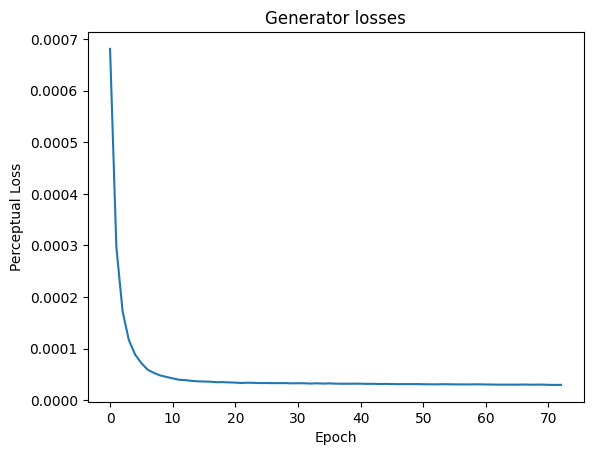

In [45]:
plt.plot(gen_losses)
plt.title("Generator losses")
plt.xlabel("Epoch")
plt.ylabel("Perceptual Loss")
plt.show()

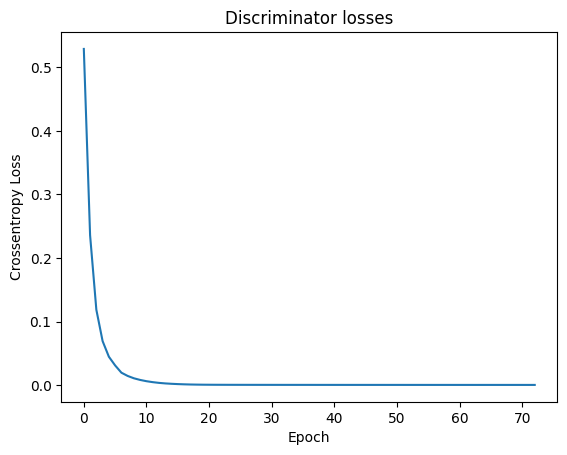

In [46]:
plt.plot(discrim_losses)
plt.title("Discriminator losses")
plt.xlabel("Epoch")
plt.ylabel("Crossentropy Loss")
plt.show()

## Saving

In [443]:
experiment = {
    "gen_losses": gen_losses,
    "discrim_losses": discrim_losses,
    "gen_state": generator.state_dict(),
    "discrim_state": discriminator.state_dict(),
    "gen_optimizer_state": gen_optimizer.state_dict(),
    "discrim_optimizer_state": discrim_optimizer.state_dict(),
    "gen_learning_rate": GEN_LEARNING_RATE,
    "discrim_learning_rate": DISCRIM_LEARNING_RATE,
    "gen_weight_decay": GEN_WEIGHT_DECAY,
    "discrim_weight_decay": DISCRIM_WEIGHT_DECAY,
    "discrim_weight": DISCRIM_WEIGHT,
    "train_time": train_time,
}

In [444]:
save_file = RESULTS_DIR / "srganreal_5iterdiscrim2.pkl"

In [445]:
if not save_file.exists():
    torch.save(experiment, save_file)
    print(f"Saved to {save_file}")

Saved to C:\Users\Mitch\stat3007_data\results\srganreal_5iterdiscrim2.pkl


## Generated Examples

In [52]:
generator = generator.to("cpu")

In [53]:
loader = DataLoader(train_patches, batch_size=100)
(low_res, high_res) = next(loader.__iter__())

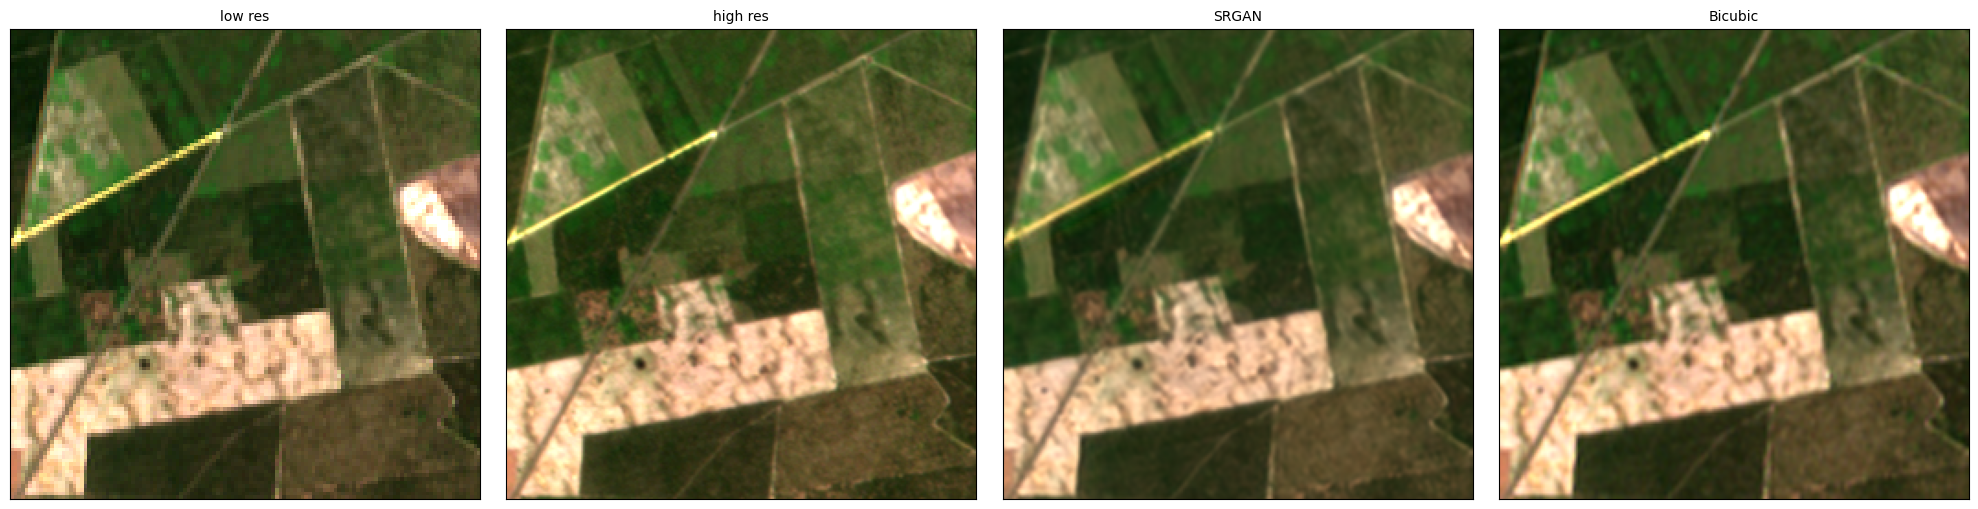

In [58]:
import random

index = random.randint(0, len(low_res) - 1)

low_res_example = low_res[index]
high_res_example = high_res[index]
out = generator(low_res_example.unsqueeze(0)).detach().clamp(0, 1)
bicubic_out = interpolate(
    low_res_example.unsqueeze(0),
    size=(256, 256),
    mode="bicubic",
).float()
plot_gallery(
    [
        adjust_brightness(low_res_example, 2).permute(1, 2, 0),
        adjust_brightness(high_res_example, 2).permute(1, 2, 0),
        adjust_brightness(out[0], 2).permute(1, 2, 0),
        adjust_brightness(bicubic_out[0], 2).permute(1, 2, 0),
    ],
    titles=["low res", "high res", "SRGAN", "Bicubic"],
    xscale=5,
    yscale=5,
)

In [117]:
loader = DataLoader(test_patches, batch_size=300)
(low_res, high_res) = next(loader.__iter__())

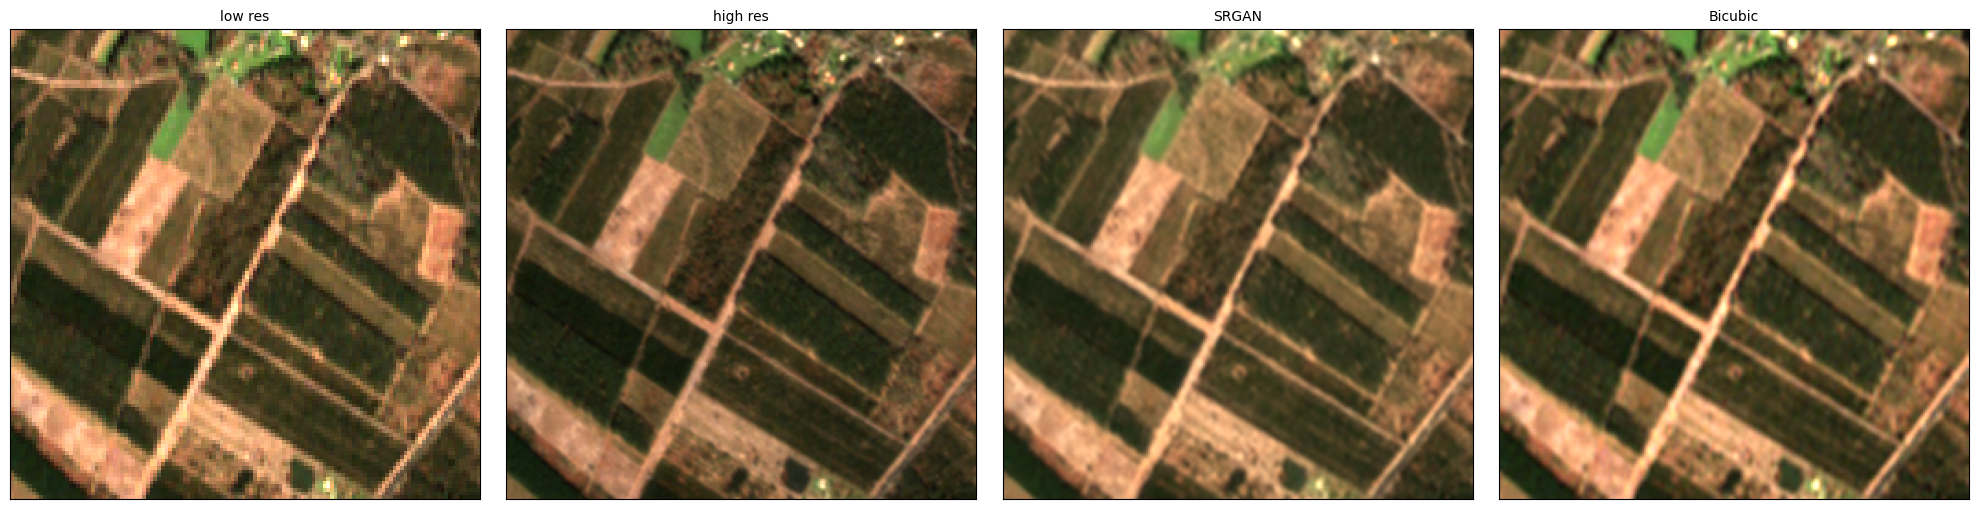

In [60]:
import random

index = random.randint(0, len(low_res) - 1)

low_res_example = low_res[index]
high_res_example = high_res[index]

out = generator(low_res_example.unsqueeze(0)).detach().clamp(0, 1)[0]
out = adjust_brightness(out, 2)

bicubic_out = (
    interpolate(low_res_example.unsqueeze(0), size=(256, 256), mode="bicubic")
    .float()
    .clamp(0, 1)
)[0]
bicubic_out = adjust_brightness(bicubic_out, 2)

low_res_example = adjust_brightness(low_res_example, 2)
high_res_example = adjust_brightness(high_res_example, 2)

plot_gallery(
    [
        low_res_example.permute(1, 2, 0),
        high_res_example.permute(1, 2, 0),
        out.permute(1, 2, 0),
        bicubic_out.permute(1, 2, 0),
    ],
    titles=["low res", "high res", "SRGAN", "Bicubic"],
    xscale=5,
    yscale=5,
)

## Save images

In [ ]:
IMAGE_DIR = RESULTS_DIR / "images"

In [ ]:
index

In [ ]:
srgan_file = IMAGE_DIR / f"{index}srgan.png"
bicubic_file = IMAGE_DIR / f"{index}bicubic.png"
low_res_file = IMAGE_DIR / f"{index}lowres.png"
high_res_file = IMAGE_DIR / f"{index}highres.png"

In [ ]:
save_image(low_res_example, low_res_file)
save_image(high_res_example, high_res_file)
save_image(out, srgan_file)
save_image(bicubic_out, bicubic_file)

## Metrics

In [48]:
del loader

NameError: name 'loader' is not defined

In [75]:
from super_resolution.src.testing import compute_metrics

In [76]:
# 256 is largest I can handle on cpu
metric_loader = DataLoader(test_patches, batch_size=min(len(test_patches), 256))

In [77]:
metrics = compute_metrics(lambda x: generator(x).clamp(0, 1), metric_loader)

100%|███████████████████████████████████████████████████████████████| 14/14 [15:47<00:00, 67.66s/it]


In [78]:
metrics

Metrics(mse=3.00678170138521e-05, psnr=45.23168727329799, ssim=0.987772775547845, fid=0.82745361328125)

In [79]:
bicubic_metrics = compute_metrics(
    lambda x: interpolate(x, size=(256, 256), mode="bicubic"), metric_loader
)

100%|███████████████████████████████████████████████████████████████| 14/14 [09:37<00:00, 41.28s/it]


In [80]:
bicubic_metrics

Metrics(mse=4.024813668885534e-05, psnr=43.96280016217913, ssim=0.9836511441639492, fid=1.3964385986328125)